In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations
from models._markets import FixedInfiniteMarket, FixedFiniteMarket, CentralBudget, RandomBudget, GreedyKnapsack, BayesianMarket, BudgetedMarket, SingleMindedQuery, WassersteinMarket
from models._loss_functions import *
from models._simulators import FixedBudgetDistSimulator, EndogenousBudgetDistSimulator

plt.style.use('config/publication.mplstyle')
cpal = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = plt.rcParams['axes.prop_cycle'].by_key()['linestyle']
mark = plt.rcParams['axes.prop_cycle'].by_key()['marker']

In [2]:
val_path = 'data/valuation/dist_valuation_st_norm_N_d_8_N_r_50.pkl'
with open(val_path, 'rb') as f:
    valuator = pkl.load(f)

# Exogenous Budget Simulations

In [3]:
N_d = valuator.N_d
N_r = valuator.N_r
agg = valuator.agg
Z_x = valuator.Z
α_bounds = valuator.α_bounds
β_bounds = valuator.β_bounds

θ_bounds = [0,1]
s_δ = np.ones(1)
s_θ = np.ones(1)
s_ρ = np.array([-0.999, 0, 0.999])
θ_Z = st.uniform
L_r = np.max(valuator.ΔL, axis=2) # assume reference is max loss for each run and metric
seed = 1345
metrics = valuator.metrics
markets = [RandomBudget,
           GreedyKnapsack,
           SingleMindedQuery,
           FixedFiniteMarket,
           FixedInfiniteMarket,
           CentralBudget
           ]
sim = FixedBudgetDistSimulator(
    valuator=valuator,
    θ_bounds=θ_bounds,
    markets=markets,
    metrics=valuator.metrics[0:8],
    s_θ=s_θ, s_ρ=s_ρ, s_δ=s_δ, N_b=10)

In [4]:
sim.run(L_r=L_r,corr_metric_id=0, seed=seed)
with open('data/procurement/sim_norm_fixed_corr_{}_{}.pkl'.format(N_d,N_r), 'wb') as f:
    pkl.dump(sim, f)

  0%|          | 0/50 [00:00<?, ?it/s]

Set parameter Username


gurobipy.gurobipy INFO  Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-29


gurobipy.gurobipy INFO  Academic license - for non-commercial use only - expires 2025-10-29


In [4]:
N_d = 8
N_r = 50
with open('data/procurement/sim_norm_fixed_corr_{}_{}.pkl'.format(N_d,N_r), 'rb') as f:
    sim = pkl.load(f)

## Market Mechanisms

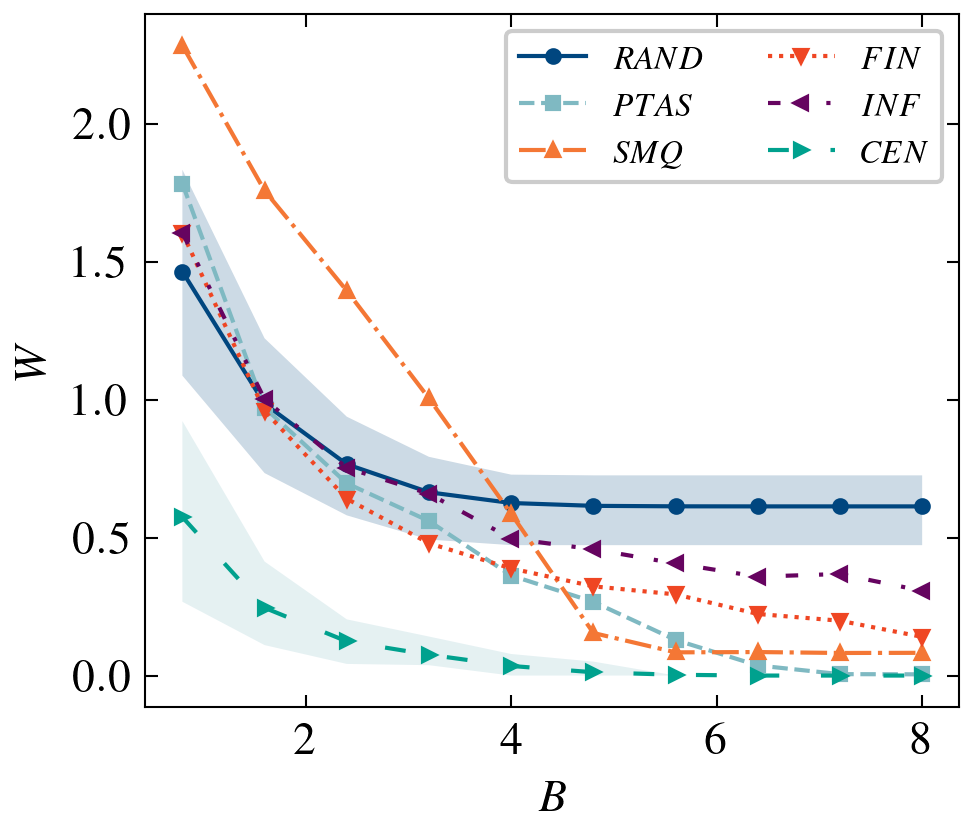

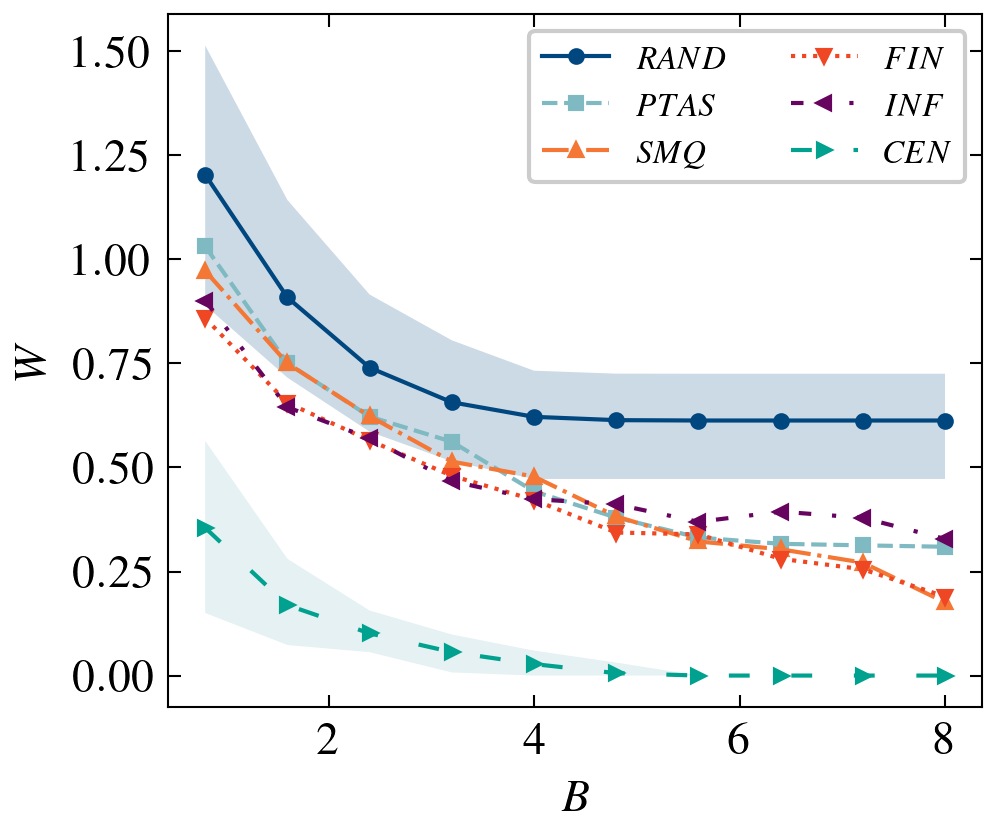

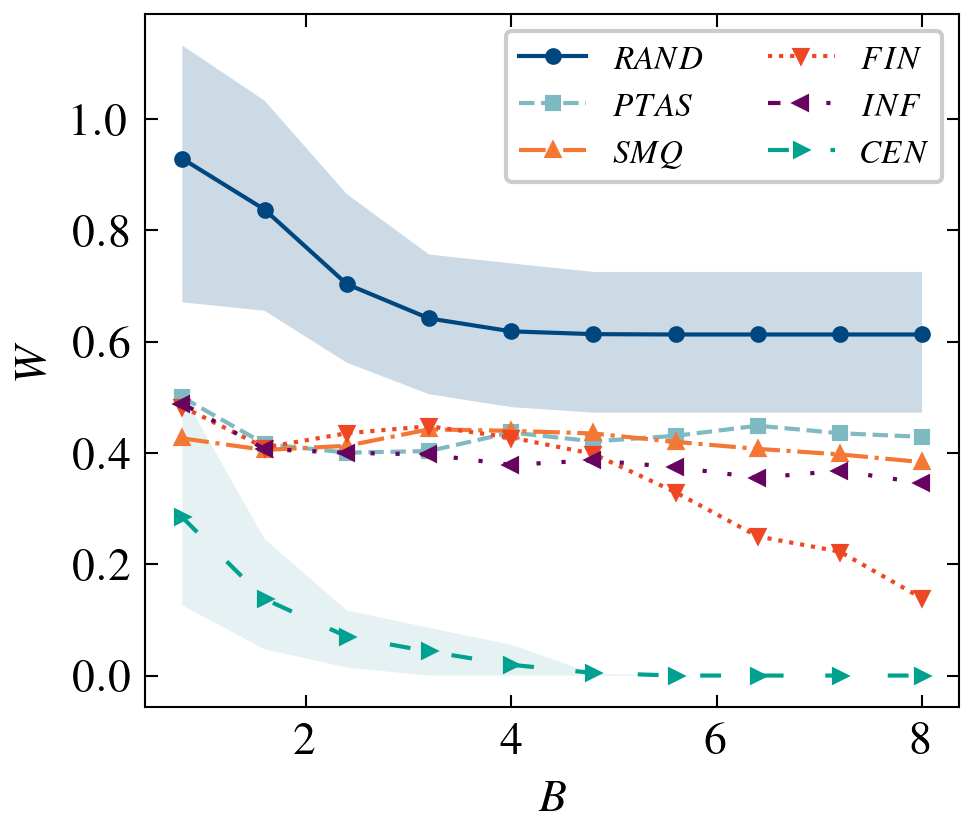

In [5]:
labels = [r"$RAND$",
          r"$PTAS$",
          r"$SMQ$",
          r"$FIN$",
          r"$INF$",
          r"$CEN$"]
l = 0
for j in range(len(sim.s_ρ)):
    fig, axes = plt.subplots()
    for m in range(len(sim.markets)):
        axes.plot(sim.s_B,np.mean(sim.V_act[:,j,:,l,m], axis = 0),
                 label = labels[m])
        if m ==0 or m == 5:
            axes.fill_between(
                sim.s_B,
                np.nanquantile(sim.V_act[:,j,:,l, m],0.1,axis=0),
                np.nanquantile(sim.V_act[:,j,:,l, m],0.90,axis=0),
                alpha = 0.2)
    # axes.set_title(r'$\rho = {}$'.format(sim.s_ρ[j]))
    axes.set_xlabel('$B$')
    axes.set_ylabel('$W$')
    axes.legend(ncol=2)
    fig.savefig('figures/procurement/fixed_budget_wass_{}.pdf'.format(j))

In [6]:
# Average per unit value across 50 runs for Wasserstein for the three correlation scenarios.
[np.mean(sim.θ[:,i]*sim.ΔL[:,0,:N_d]) for i in range(3)]

[0.7353832581523824, 0.8910912069528132, 0.9838125966795167]

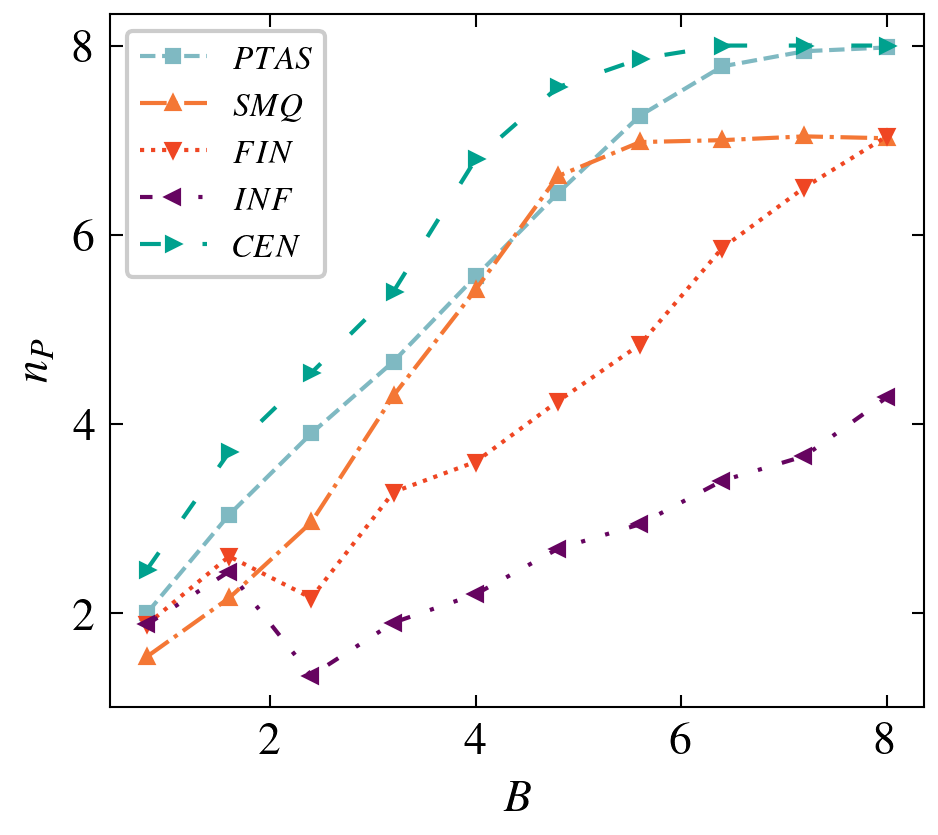

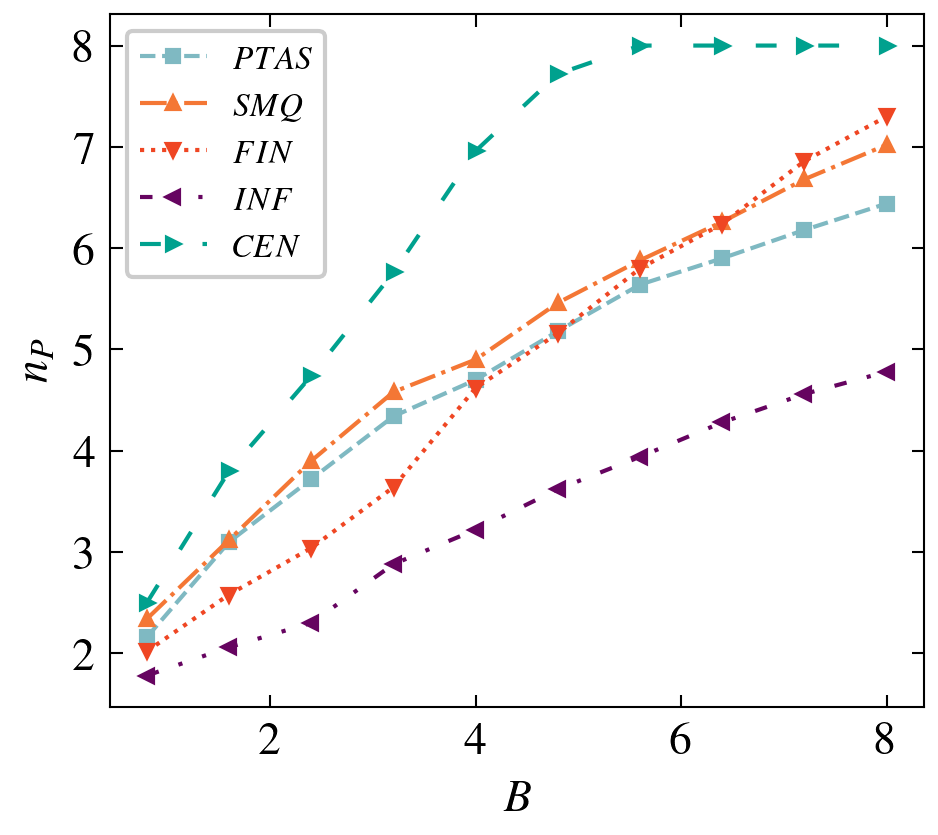

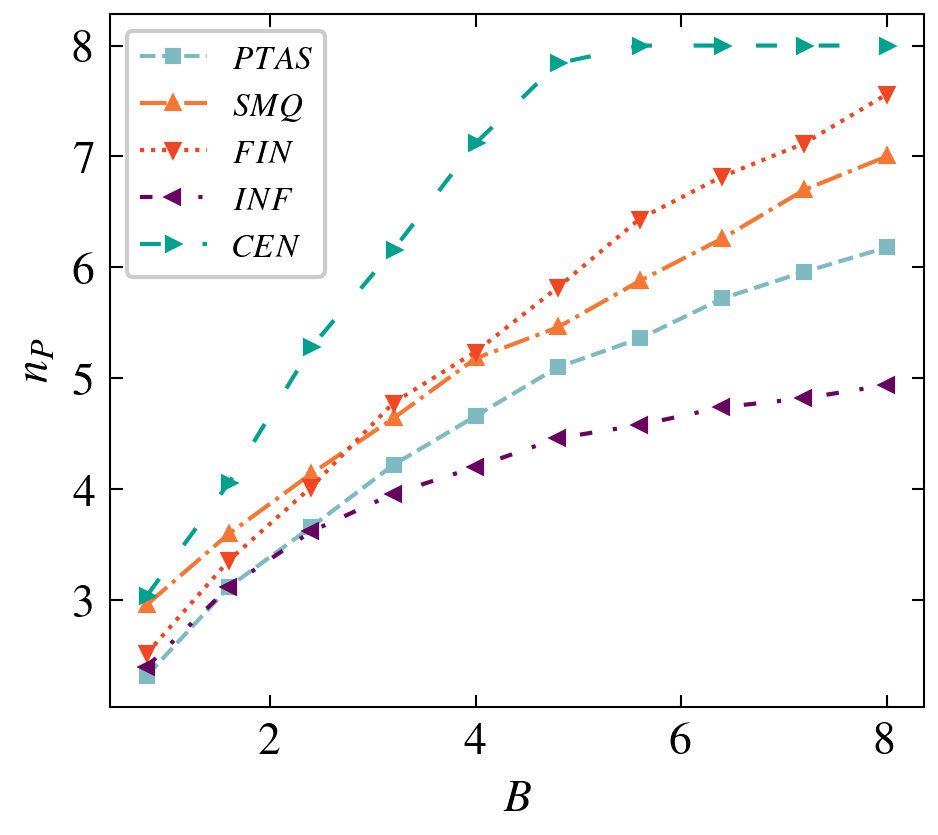

In [7]:
labels = [r"$RAND$",
          r"$PTAS$",
          r"$SMQ$",
          r"$FIN$",
          r"$INF$",
          r"$CEN$"]
l =0
r= 0
for j in range(len(sim.s_ρ)):
    fig, axes = plt.subplots()
    for n,m in enumerate(range(1,len(sim.markets))):
        axes.plot(sim.s_B,
                  np.mean(sim.q[:,j,:,l,m].sum(axis=2), axis = 0),
                 label = labels[m],
                  c= cpal[n+1], ls=ls[n+1], marker = mark[n+1])
    # axes.set_title(r'$\rho = {}$'.format(sim.s_ρ[j]))
    axes.set_xlabel('$B$')
    axes.set_ylabel('$n_P$')
    axes.legend()
    fig.savefig('figures/procurement/fixed_budget_num_{}.pdf'.format(j))

## Statistical Distances

In [10]:
def get_actual_value(U, q, C, L_r):
    q_act = get_idx(q)
    U_act = U[list(C).index(tuple(q_act))] if tuple(q_act) != () else L_r
    return U_act, q_act

def get_idx(q):
    return np.arange(len(q))[q.astype(bool)]

# Calculate average percentage error using different distances across all the tasks (MAE, MSE, MPL & NV)
L_r = np.max(sim.valuator.ΔL, axis=2)
dist_metrics = np.arange(5)
val_metrics = np.arange(6,17)

Ω_act = np.zeros((len(val_metrics),len(dist_metrics),
                  sim.N_r,sim.N_b,len(sim.s_ρ),len(sim.markets)))
Ω_act_perc = np.zeros_like(Ω_act)
for i, val in enumerate(val_metrics):
    U = sim.ΔL[:,val,:] # target metric
    for j,dist in enumerate(dist_metrics):
        for k in range(sim.N_r):
            for l in range(sim.N_b):
                for m in range(len(sim.s_ρ)):
                    for n in range(len(sim.markets)):
                        Ω_act[i,j,k,l,m,n] = (
                            get_actual_value(
                                U[k],
                                sim.q[k,m,l,dist,n],
                                sim.valuator.C, L_r[k,val])[0]
                        )
                        Ω_act_perc[i,j,k,l,m] = (
                                1-Ω_act[i,j,k,l,m]/L_r[k,val])

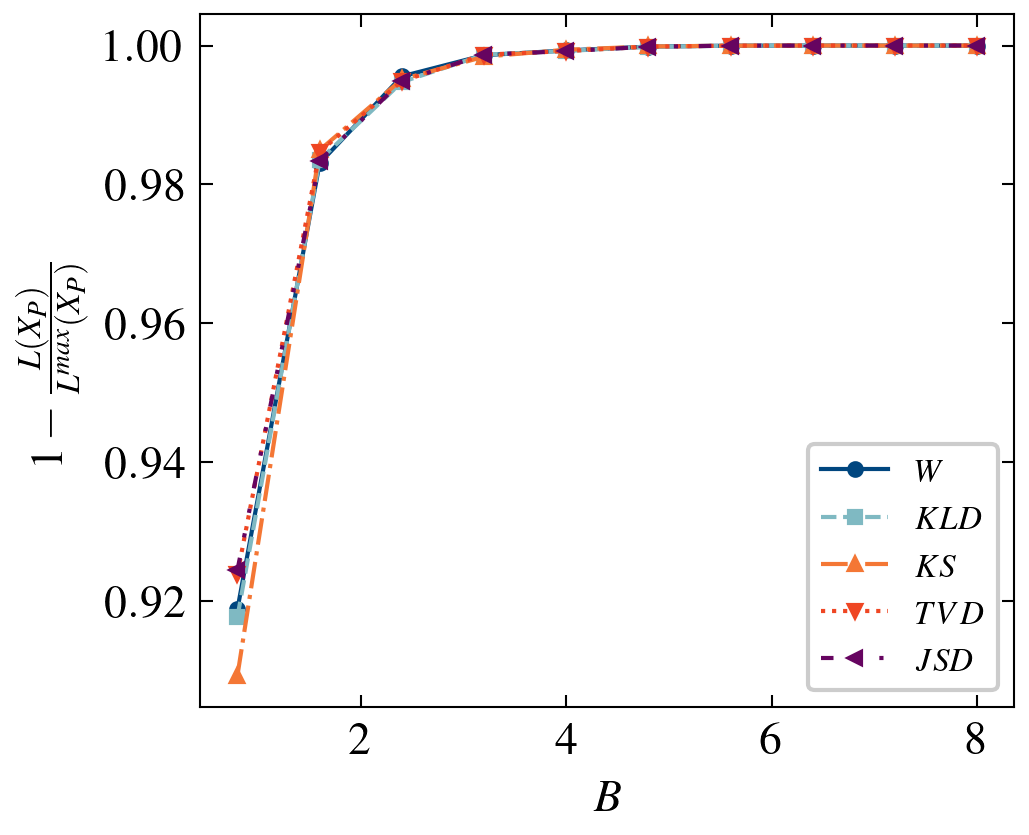

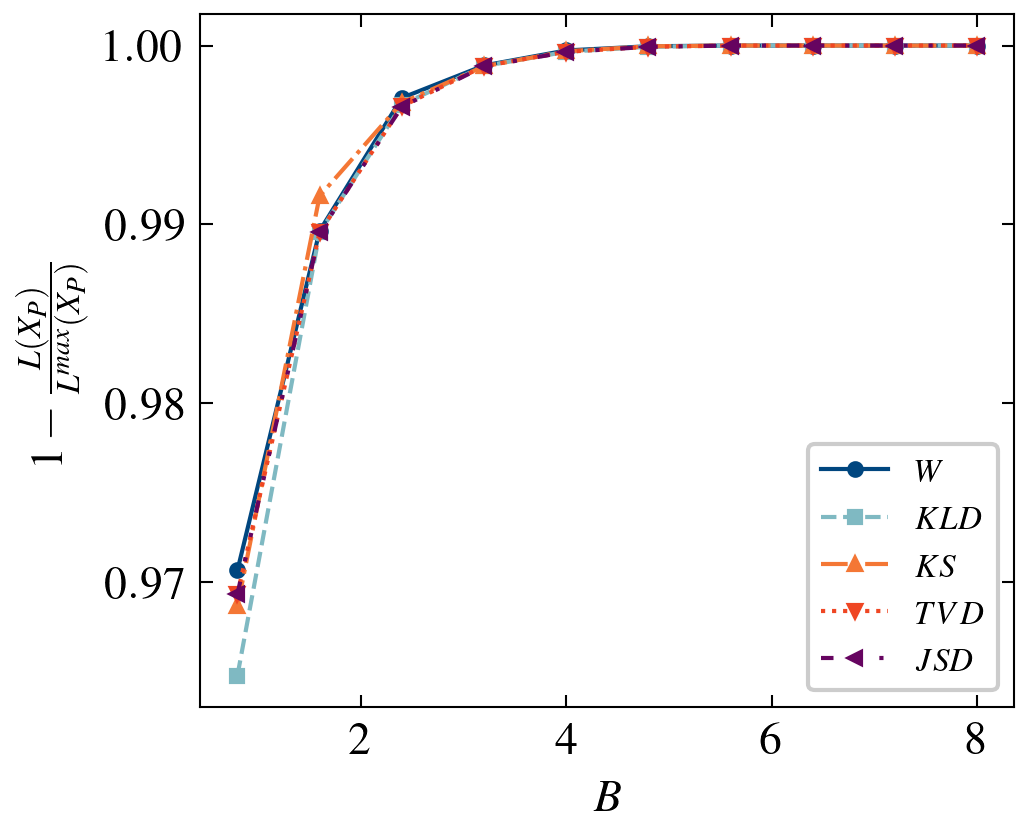

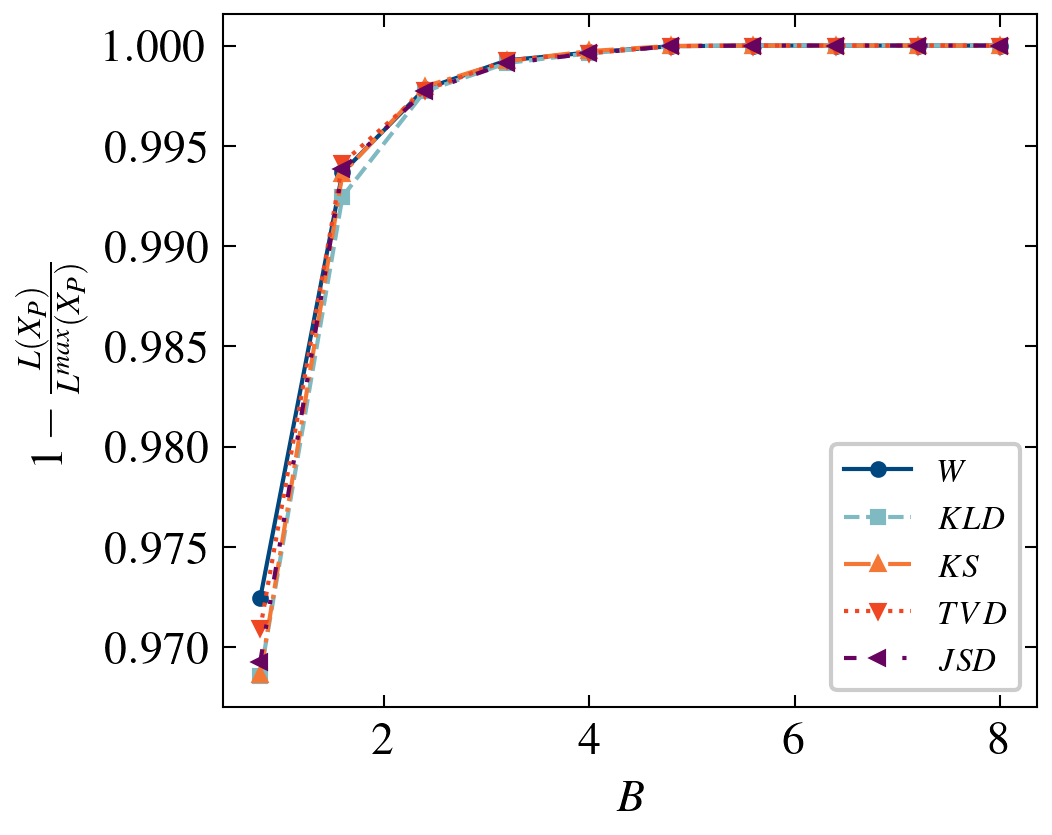

In [11]:
# Calculate average percentage error using different distances across all the tasks (MAE, MSE, MPL & NV)
L_r = np.max(sim.valuator.ΔL, axis=2)
dist_metrics = np.arange(5)
val_metrics = np.arange(6,17)
labels = ['$W$','$KLD$','$KS$',
          r"$TVD$",
          r"$JSD$",
          r"$MAE$",
          r"$RMSE$"]
val = 1
m = 5
corr = 0
for k, ρ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for i,dist in enumerate(dist_metrics):
        axes.plot(sim.s_B,Ω_act_perc[val,i,:,:,k,m].mean(axis = 0),
                 label = labels[dist])
    axes.set_xlabel('$B$')
    axes.set_ylabel(r'$1-\frac{L(X_P)}{L^{max}(X_P)}$')
    # axes.set_title(r'$\rho = {}$'.format(ρ))
    # axes.set_ylim([0.91,0.92])
    axes.legend()
    fig.savefig('figures/procurement/fixed_budget_cen_acc_{}.pdf'.format(k))

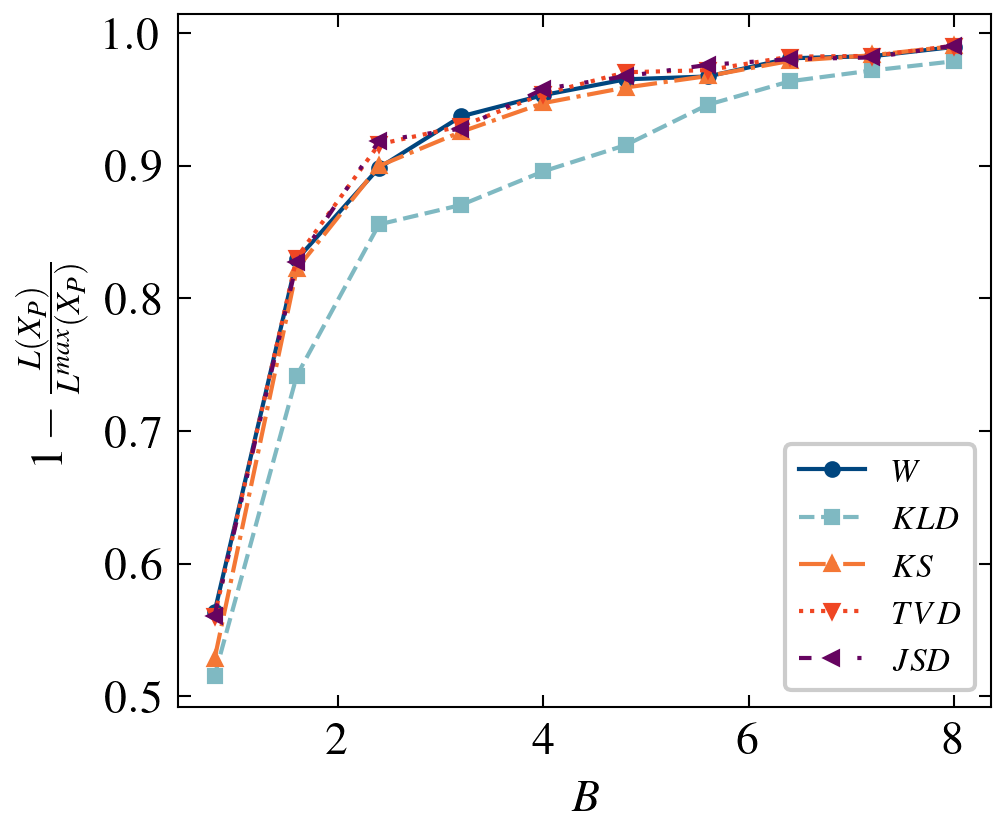

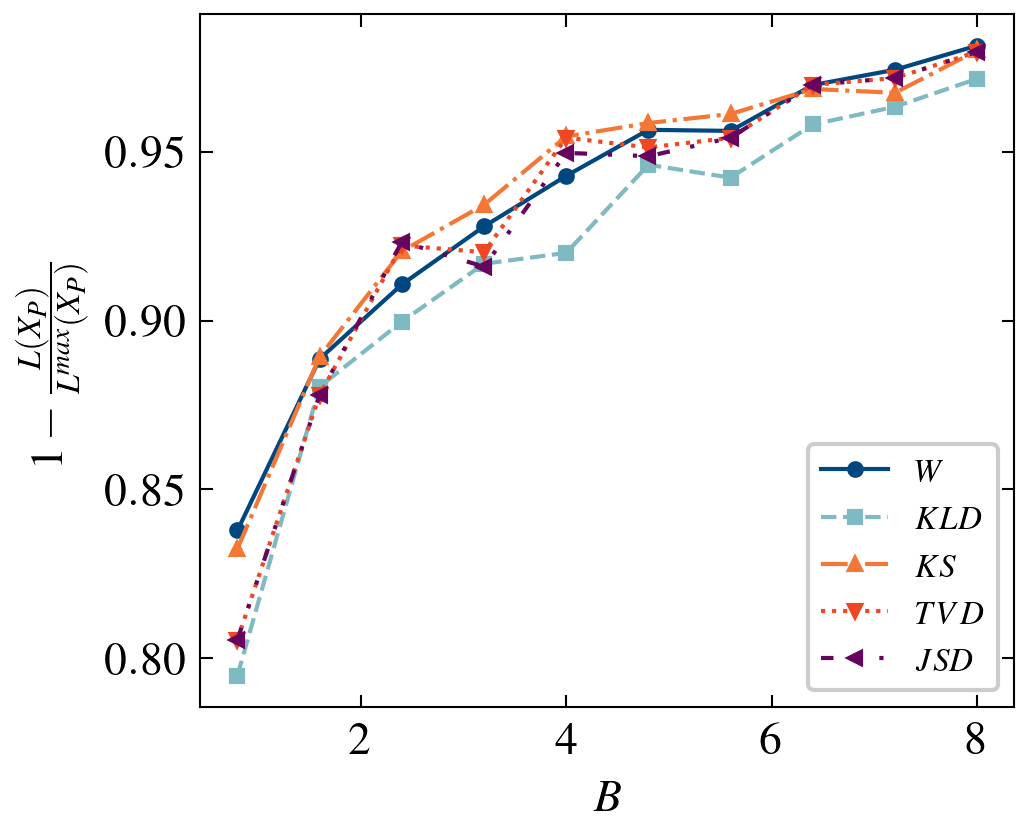

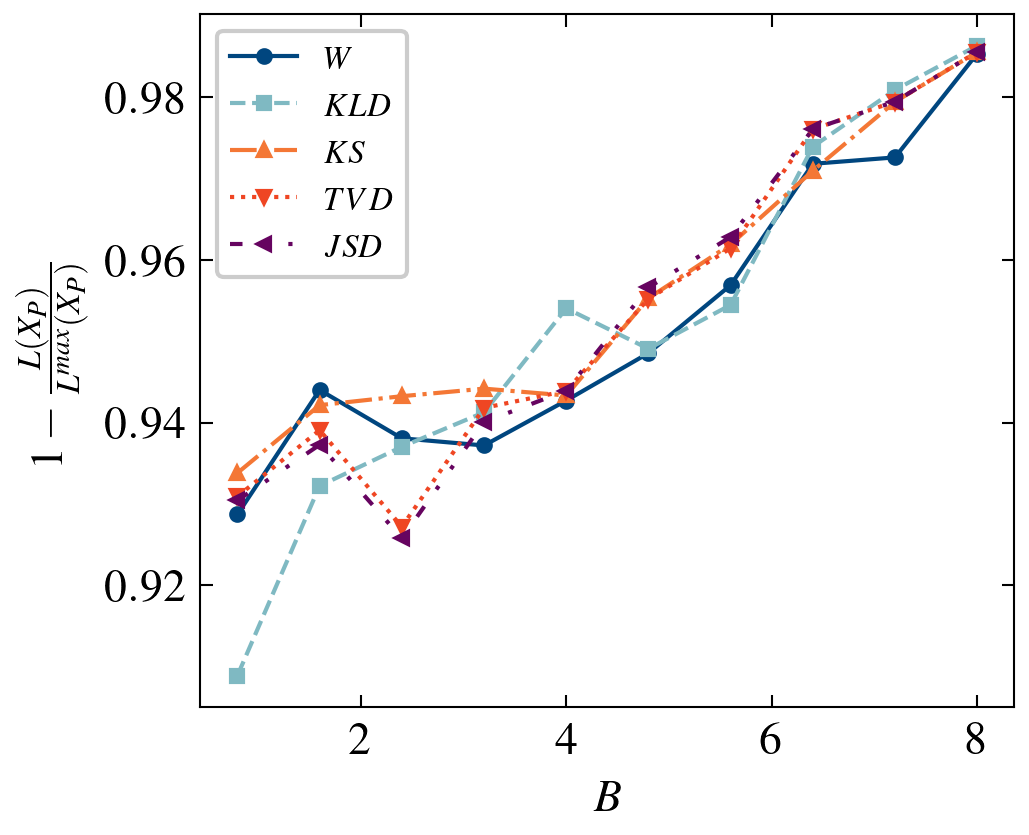

In [12]:
n = 3
for k, ρ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for i,dist in enumerate(dist_metrics):
        axes.plot(sim.s_B,Ω_act_perc[:,i,:,:,k,n].mean(axis = 0).mean(axis = 0),
                 label = labels[dist])
    axes.set_xlabel('$B$')
    axes.set_ylabel(r'$1-\frac{L(X_P)}{L^{max}(X_P)}$')
    # axes.set_title(r'$\rho = {}$'.format(ρ))
    # axes.set_ylim([0.5,1.001])
    axes.legend()
    fig.savefig('figures/procurement/fixed_budget_fin_acc_{}.pdf'.format(k))

## Unified Valuation Metric

In [14]:
import numpy as np

In [13]:
from models._markets import WassersteinMarket
seed = 1345
δ = 10**-5
Δ = 1
valuator.Z =st.norm
L_r = np.max(valuator.ΔL, axis=2)
s_ϵ = np.logspace(-1,2,10)
sim.N_r = 50
sim.markets = markets = [
           FixedFiniteMarket,
           FixedInfiniteMarket,
           CentralBudget
           ]
V = np.zeros((sim.N_r, len(sim.s_ρ),len(s_ϵ), 4, len(valuator.C)))
sim.V_obj_dp = np.zeros((sim.N_r, len(sim.s_ρ),len(s_ϵ), sim.N_b,
                               4, len(sim.markets)))
sim.V_act_dp = np.zeros_like(sim.V_obj_dp)
sim.obj_dp = np.zeros_like(sim.V_obj_dp)
sim.q_dp = np.zeros((sim.N_r, len(sim.s_ρ),len(s_ϵ), sim.N_b,
                               4, len(sim.markets), sim.N_d))
sim.t_dp = np.zeros_like(sim.q_dp)
sim.t_Φ_dp = np.zeros_like(sim.q_dp)
sim.ϵ = np.zeros((sim.N_r, len(sim.s_ρ),len(s_ϵ),sim.N_d))
sim.θ_dp = np.zeros_like(sim.ϵ)
np.random.seed(seed)

In [6]:
for i in tqdm(range(sim.N_r)):
    α_T, β_T = valuator.dist_aggregator(valuator.α[i], valuator.β[i])
    for j, ρ in enumerate(sim.s_ρ):
        for k,ϵ_max in enumerate(s_ϵ):
            sim.ϵ[i, j, k] = np.random.uniform(0.1,ϵ_max,sim.N_d)
            sim.θ_dp[i, j, k] = sim.generate_reserve_prices(
                sim.θ_bounds[0],
                sim.θ_bounds[1],
                ρ, sim.ϵ[i,j,k], seed)  # reserve prices
            β_in = np.sqrt(valuator.β[i]**2 + (2*(Δ**2)*np.log(1.25/δ))/sim.ϵ[i,j,k]**2)
            α_T_dp, β_T_dp = valuator.dist_aggregator(valuator.α[i], β_in)
            for l, B in enumerate([sim.s_B[1]]):
                for m in range(4):
                    # generate value 0: V=e, 1:V=W, 2:V=W+e, 3:V=W+We
                    if m == 0:
                        #V = 1/∑ϵ
                        for n, c in enumerate(valuator.C):
                            V[i,j,k,m,n] = 1/np.sum(sim.ϵ[i, j,k,c])
                    elif m == 1:
                        #V = W(X_c,X_T)
                        V[i,j,k,m] = sim.ΔL[i, 0]
                    elif m ==2:
                        #V = W(X_c+X_dp_c,X_T_dp)
                        for n, c in enumerate(valuator.C):
                            β_in = np.sqrt(valuator.β[i, c]**2 + (2*(Δ**2)*np.log(1.25/δ))/sim.ϵ[i,j,k,c]**2)
                            α_C, β_C = valuator.dist_aggregator(valuator.α[i, c], β_in)
                            V[i,j,k,m,n] = WassersteinMetric().closed_form(α_C, β_C, α_T_dp, β_T_dp)
                    else:
                        #V = W(X_c,X_T_dp) + W(X_dp,0) 
                        for n, c in enumerate(valuator.C):
                            β_in = np.sqrt((2*(Δ**2)*np.log(1.25/δ))/sim.ϵ[i,j,k,c]**2)
                            α_C, β_C = valuator.dist_aggregator(valuator.α[i, c], valuator.β[i, c])
                            _, β_dp = valuator.dist_aggregator(valuator.α[i, c], β_in)
                            V[i,j,k,m,n] = (sim.ΔL[i, 0, n]
                                    # WassersteinMetric().closed_form(α_C, β_C, α_T, β_T)
                                          + WassersteinMetric().closed_form(0, β_dp, 0, 0))
                    for o, market in enumerate(sim.markets):
                        arg = {'V_c': V[i,j,k,m],
                               'θ': np.squeeze(sim.θ_dp[i, j, k]),
                               'L_r': V[i,j,k,m,:N_d].max(axis=-1)}
                        run_arg = {}
                        if issubclass(market, BayesianMarket):
                            arg['θ_params'] = sim.θ_bounds
                            arg['Z'] = st.uniform
                        if issubclass(market, WassersteinMarket):
                            run_arg['budget'] = True
                            run_arg['endogenous'] = False
                            arg['K'] = 1
                            arg['δ'] = 0.95
                        if issubclass(market, BudgetedMarket):
                            arg['B'] = B
                        
                        idx = (i, j, k, l, m,o)
                        market_instance = market(**arg)
                        res_temp = market_instance.run(**run_arg)
                        sim.V_obj_dp[idx] = res_temp['V_obj']
                        sim.V_act_dp[idx] = res_temp['V_act']
                        sim.obj_dp[idx] = res_temp['obj']
                        sim.q_dp[idx] = res_temp['q']
                        sim.t_dp[idx] = res_temp['t']
                        sim.t_Φ_dp[idx] = market_instance.shapley(sim.q_dp[idx])

  0%|          | 0/50 [00:00<?, ?it/s]

Set parameter Username


gurobipy.gurobipy INFO  Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-29


gurobipy.gurobipy INFO  Academic license - for non-commercial use only - expires 2025-10-29


In [7]:
# Generate true dataset - assuming mean estimation
met = RootMeanSquaredError()
V_rmse = np.zeros((sim.N_r,len(sim.s_ρ),len(s_ϵ),valuator.N_c))
for i in tqdm(range(sim.N_r)):
    for j, ρ in enumerate(sim.s_ρ):
        for k,ϵ_max in enumerate(s_ϵ):
            β_in = np.sqrt(valuator.β[i]**2 + (2*(Δ**2)*np.log(1.25/δ))/sim.ϵ[i,j,k]**2)
            α_T, β_T = valuator.dist_aggregator(valuator.α[i], β_in)
            for o, c in enumerate(valuator.C):
                β_in = np.sqrt(valuator.β[i, c]**2 + (2*(Δ**2)*np.log(1.25/δ))/sim.ϵ[i,j,k,c]**2)
                α_C, β_C = valuator.dist_aggregator(valuator.α[i, c], β_in)
                V_rmse[i,j,k,o] = met.closed_form(α_C, β_C,α_T, β_T)

  0%|          | 0/50 [00:00<?, ?it/s]

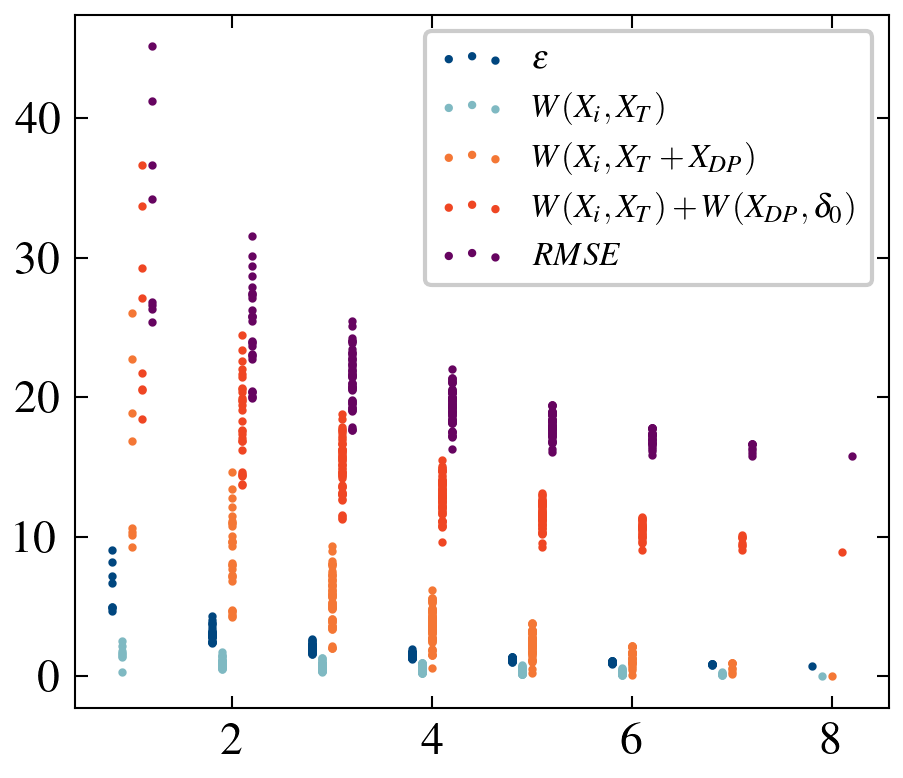

In [8]:
plt.scatter(valuator.C_n-0.2, V[0,0,1,0], s=1, label = '$\epsilon$')
plt.scatter(valuator.C_n-0.1, V[0,0,1,1], s=1, label = '$W(X_i, X_T)$')
plt.scatter(valuator.C_n, V[0,0,1,2], s=1, label = '$W(X_i, X_T + X_{DP})$')
plt.scatter(valuator.C_n+0.1, V[0,0,1,3], s=1, label = '$W(X_i, X_T) + W(X_{DP}, \mathfrak{\delta}_0)$')
plt.scatter(valuator.C_n+0.2, V_rmse[0,0,1], s=1, label = '$RMSE$')
plt.legend();

In [9]:
i,j,k = 0,0,0
print(np.corrcoef(V_rmse[i,j,k],V[i,j,k,0])[1,0])
print(np.corrcoef(V_rmse[i,j,k],V[i,j,k,1])[1,0])
print(np.corrcoef(V_rmse[i,j,k],V[i,j,k,2])[1,0])
print(np.corrcoef(V_rmse[i,j,k],V[i,j,k,3])[1,0])

0.9922474101562244
0.7853711282452115
0.9991924184267674
0.9981561138234721


In [10]:
def get_actual_value(U, q, C, L_r):
    q_act = get_idx(q)
    U_act = U[list(C).index(tuple(q_act))] if tuple(q_act) != () else L_r
    return U_act, q_act

def get_idx(q):
    return np.arange(len(q))[q.astype(bool)]

In [11]:
V_act = np.array([
    [
        [
            [
                [
                    [
                        get_actual_value(
                            V_rmse[i,j,k],
                            sim.q_dp[i,j,k,l,m,n],
                            valuator.C,
                            V_rmse[i,j,k].max())[0] 
                        for n,_ in enumerate(sim.markets)
                    ]
                    for m in range(4)
                ]
                for l in [0]#range(sim.N_b)
            ]
            for k,_ in enumerate(s_ϵ)
        ]
        for j,_ in enumerate(sim.s_ρ) 
    ]
    for i in range(sim.N_r)
])

In [13]:
# dump sim results
with open('data/procurement/sim_norm_fixed_corr_dp_{}_{}.pkl'.format(N_d,N_r), 'wb') as f:
    pkl.dump([sim, V, V_rmse, V_act,s_ϵ], f)

In [6]:
# load sim results
with open('data/procurement/sim_norm_fixed_corr_dp_{}_{}.pkl'.format(N_d,N_r), 'rb') as f:
    sim, V, V_rmse, V_act,s_ϵ = pkl.load(f)

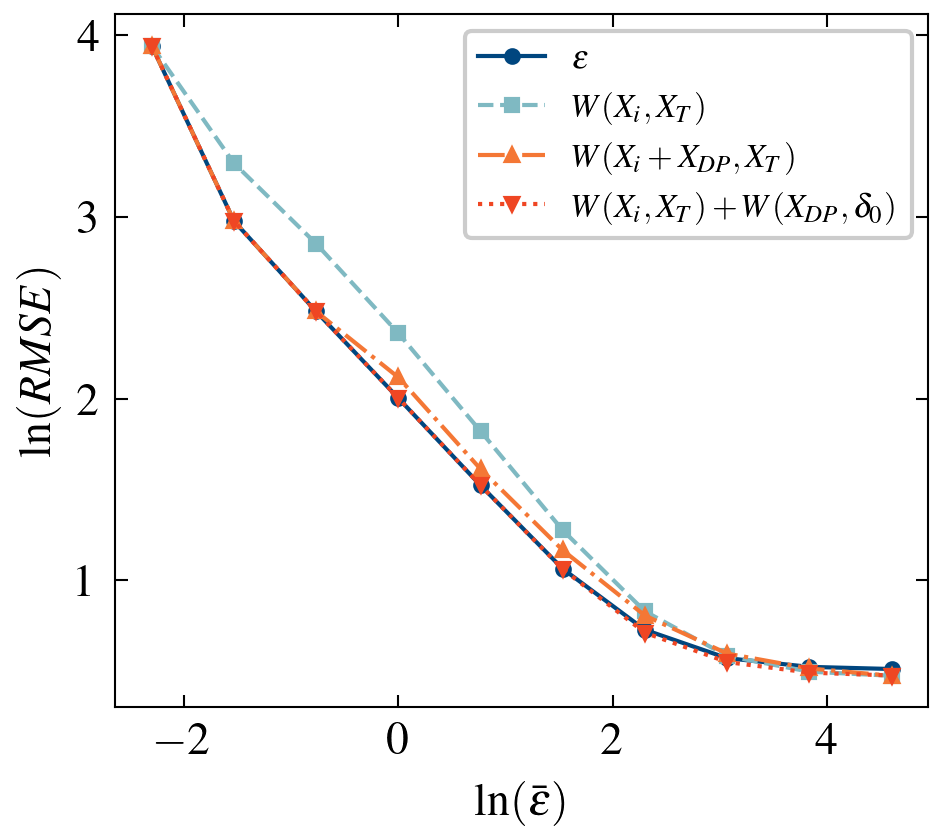

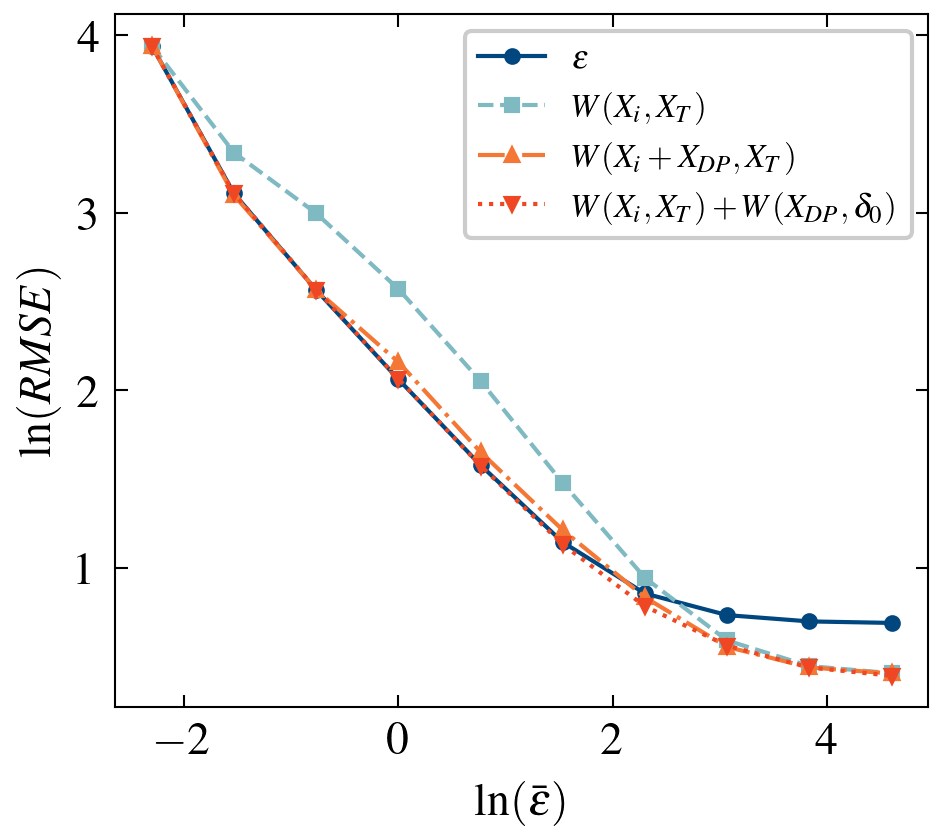

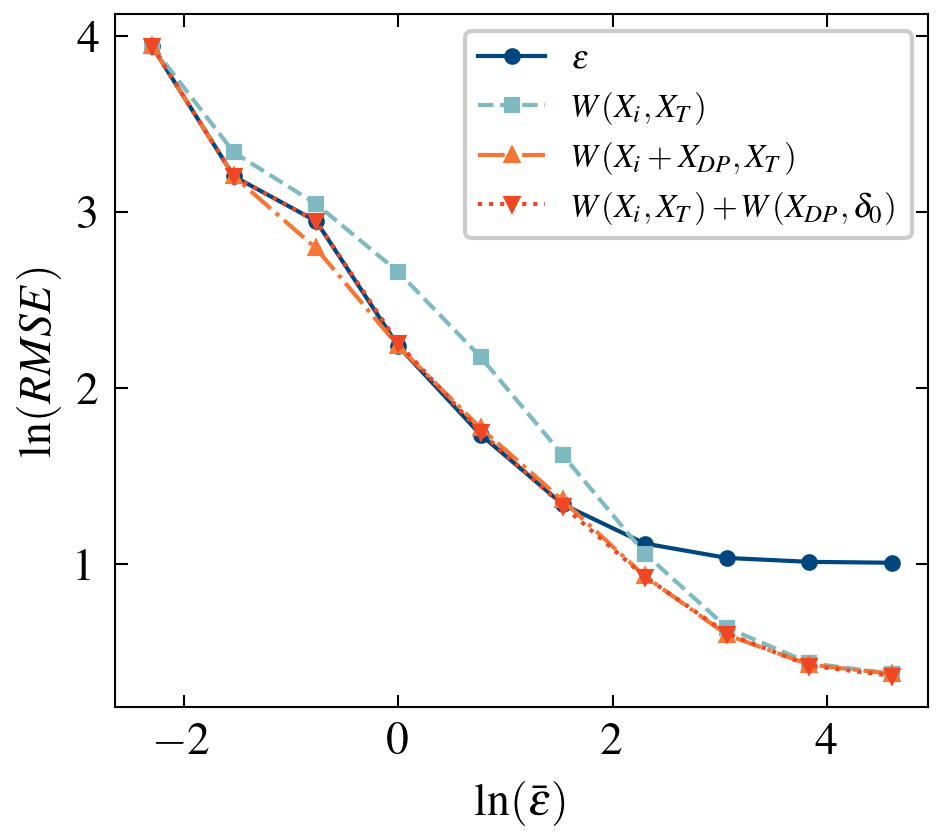

In [7]:
labels = [r"$\epsilon$",
          r"$W(X_i, X_T)$",
          r"$W(X_i + X_{DP}, X_T)$",
          r"$W(X_i, X_T) + W(X_{DP}, \mathfrak{\delta}_0)$"]
m = 0
for j in range(len(sim.s_ρ)):
    fig, axes = plt.subplots()
    axes.plot(np.log(s_ϵ),np.log(np.mean(V_act[:,j,:,0,:,m], axis = 0)),
             label = labels)
    axes.set_xlabel(r'$\ln(\bar\epsilon)$')
    axes.set_ylabel('$\ln(RMSE)$')
    axes.legend(ncol=1);
    fig.savefig('figures/procurement/fixed_budget_dp_{}.pdf'.format(j))

# Endogenous Budget Simulations

In [17]:
N_d = valuator.N_d
N_r = valuator.N_r
agg = valuator.agg
Z_x = valuator.Z
α_bounds = valuator.α_bounds
β_bounds = valuator.β_bounds

θ_bounds = [0,1]
s_δ = [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.25, 0.1, 0.001]
s_θ = np.linspace(0,2.4,13)
s_ρ = np.array([-0.999, 0, 0.999])
θ_Z = st.uniform
L_r = np.max(valuator.ΔL, axis=2) # assume reference is max loss for each run and metric
seed = 1345
met_ids = [0,0,0,0,5,6,8,9]
metrics = [valuator.metrics[i] for i in met_ids]
markets = [
           FixedFiniteMarket,
           FixedInfiniteMarket,
           CentralBudget
           ]
sim = EndogenousBudgetDistSimulator(
    valuator=valuator,
    θ_bounds=θ_bounds,
    markets=markets,
    metrics=metrics,
    s_θ=s_θ, s_ρ=s_ρ, s_δ=s_δ
)

In [17]:
sim.N_r = 50
sim.ΔL = sim.ΔL[:,met_ids] 
ref_metrics = list(range(4)) + list(range(4))
sim.run(
    L_r=np.max(valuator.ΔL, axis=2)[:,[5,6,8,9,5,6,8,9]],
    δ=0.95,
    corr_metric_id=0, 
    ref_metric=ref_metrics, 
    seed=seed
)
sim.calc_act_vals(range(len(metrics)), range(len(metrics)))
sim.run_delta(s_δ, 0, 0)
with open('data/procurement/sim_norm_endo_corr_{}_{}.pkl'.format(N_d,N_r), 'wb') as f:
    pkl.dump(sim, f)

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Saurab\.conda\envs\tf_test\lib\site-packages\scipy\stats\_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Saurab\.conda\envs\tf_test\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Saurab\Documents\GitHub\WD-Paper-Code\models\_simulators.py:234: RuntimeWarning: invalid value encountered in scalar divide
  1 - (self.Ω_act[i, j, k, l, m, n, o]
C:\Users\Saurab\Documents\GitHub\WD-Paper-Code\models\_simulators.py:234: RuntimeWarning: divide by zero encountered in scalar divide
  1 - (self.Ω_act[i, j, k, l, m, n, o]


  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
N_d = 8
N_r = 50
with open('data/procurement/sim_norm_endo_corr_{}_{}.pkl'.format(N_d,N_r), 'rb') as f:
    sim = pkl.load(f)

Comparison of:
- endogenous vs joint optimisation
- joint vs central with Wasserstein vs central with MAE
 - same as above but with MAE actuals

## Differing Objectives

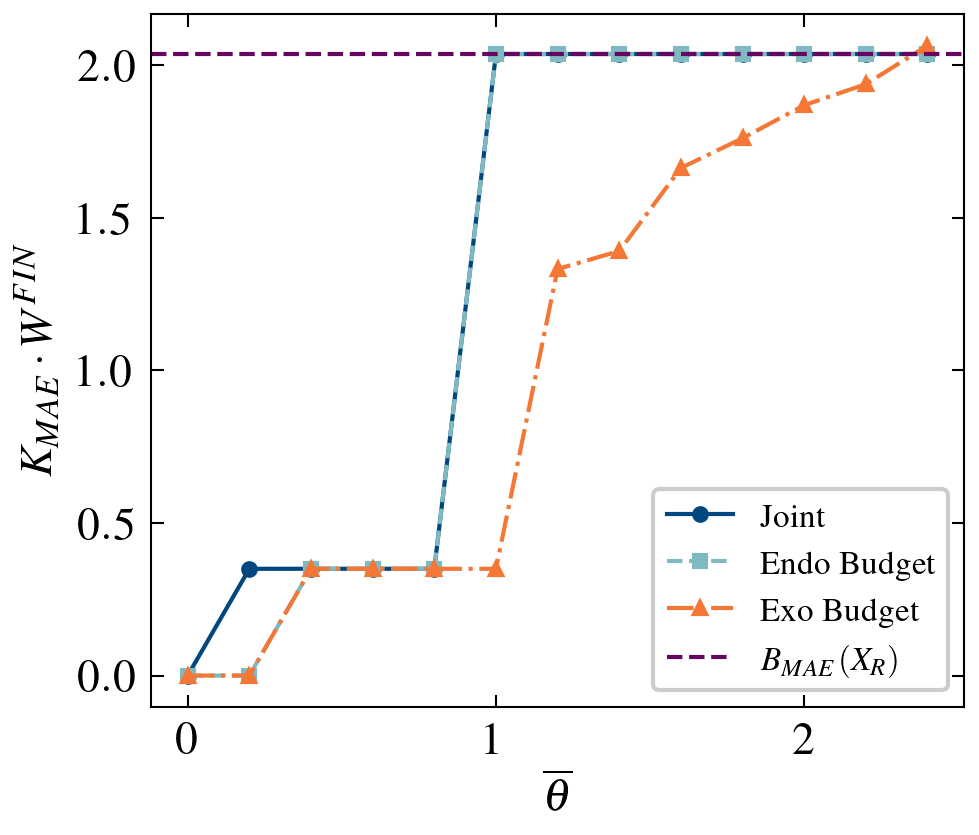

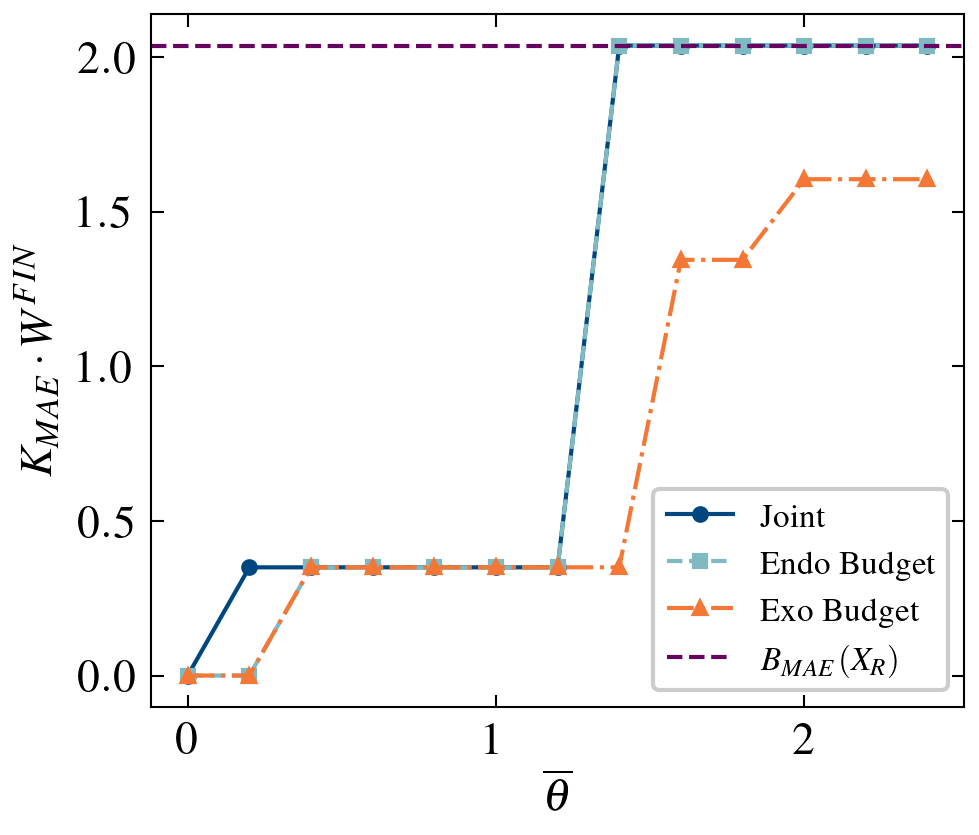

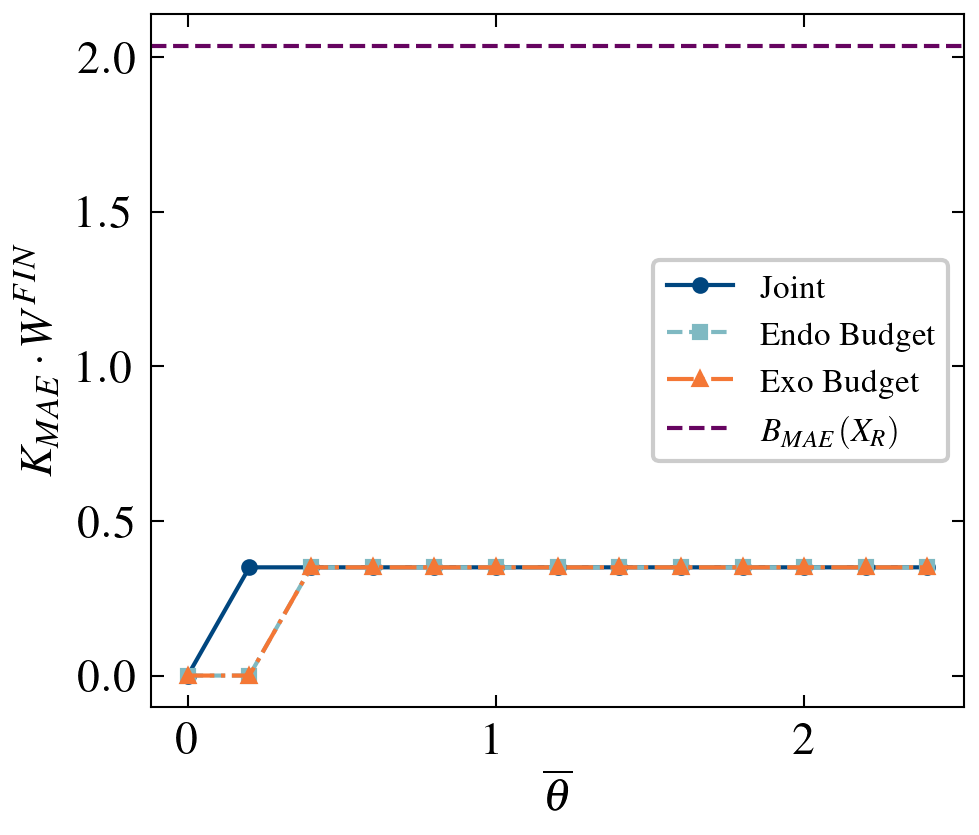

In [9]:
m = 0# market index
run = 0 # trial id
dist = 0 # Distance metric id
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,1],
              label='Joint')
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,0],
              label='Endo Budget')
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,2],
              label='Exo Budget')
    axes.axhline(sim.L_r[run,dist], c=cpal[4], ls = '--', label = r'$B_{MAE}(X_R)$')
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$K_{MAE} \cdot W^{FIN}$')
    axes.legend()
    fig.savefig('figures/procurement/endo_exp_{}.pdf'.format(corr))

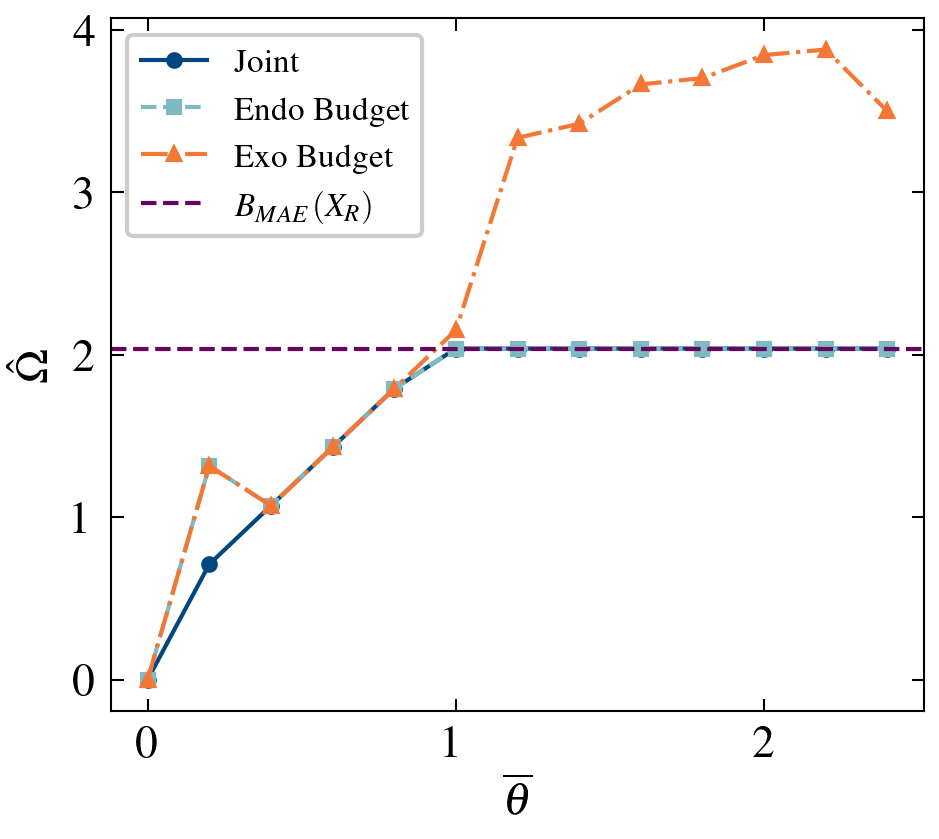

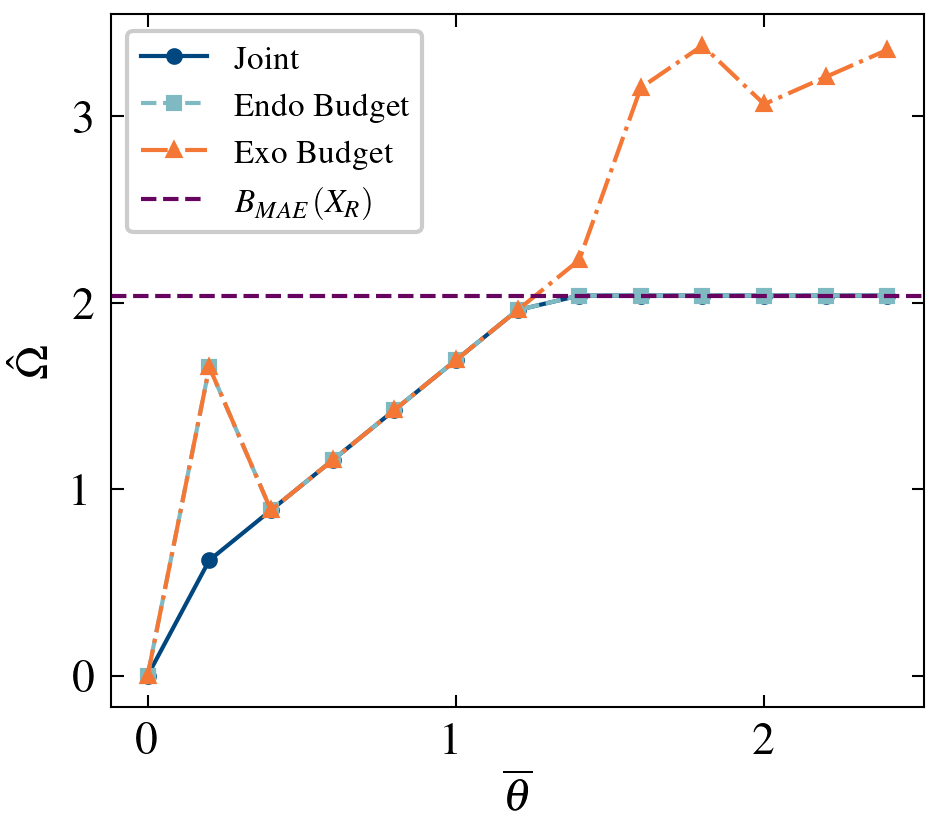

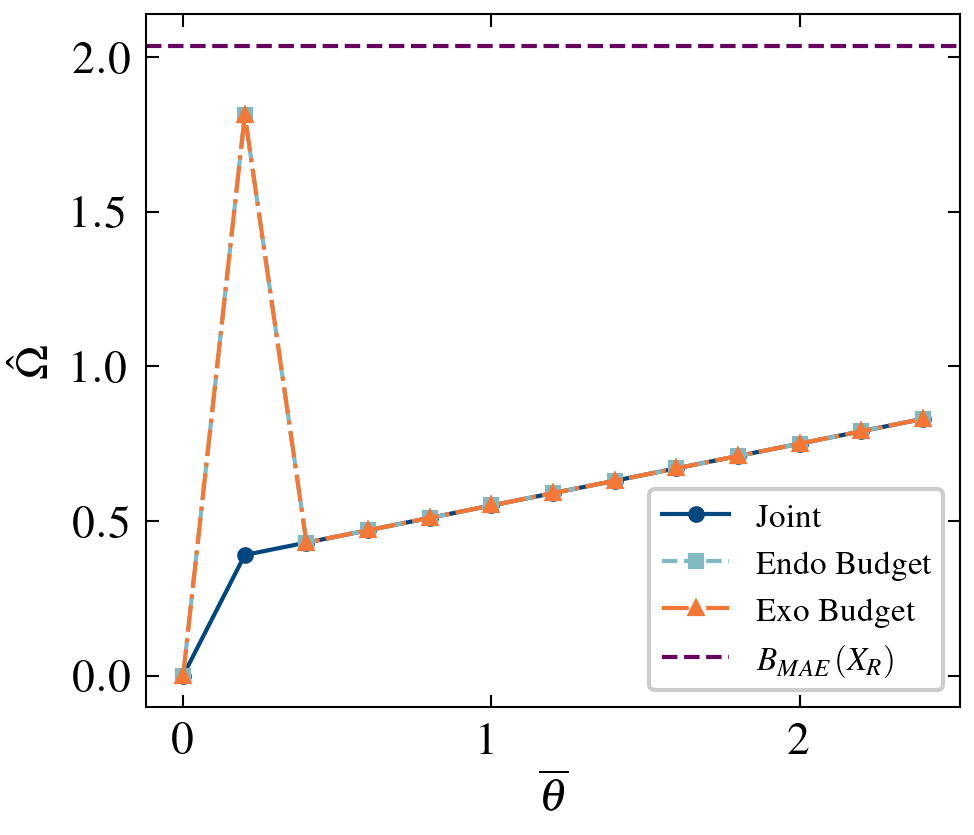

In [10]:
m = 0# market index
run = 0 # trial id
dist = 0 # Distance metric id
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,1] + sim.t[run,:,corr,dist,m,1].sum(axis=-1),
              label='Joint')
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,0] + sim.t[run,:,corr,dist,m,0].sum(axis=-1),
              label='Endo Budget')
    axes.plot(sim.s_θ,
              sim.V_obj[run,:,corr,dist,m,2] + sim.t[run,:,corr,dist,m,2].sum(axis=-1),
              label='Exo Budget')
    axes.axhline(sim.L_r[run,dist], c=cpal[4], ls = '--', label = r'$B_{MAE}(X_R)$')
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$\hat\Omega$')
    axes.legend()
    fig.savefig('figures/procurement/endo_cost_{}.pdf'.format(corr))

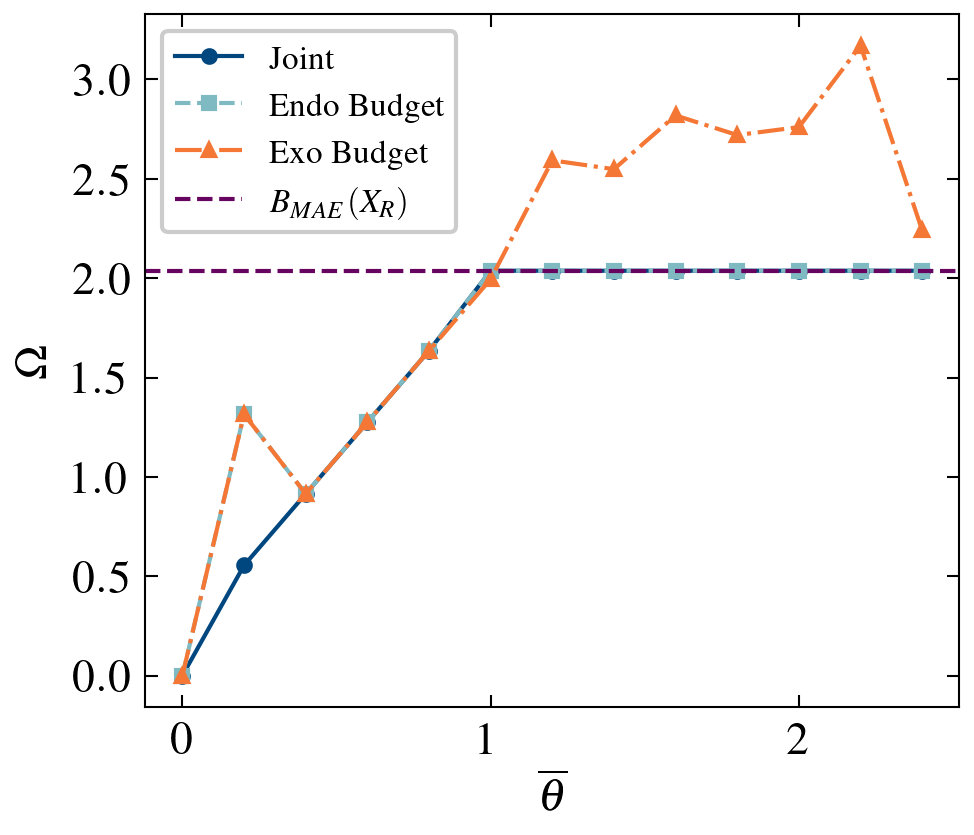

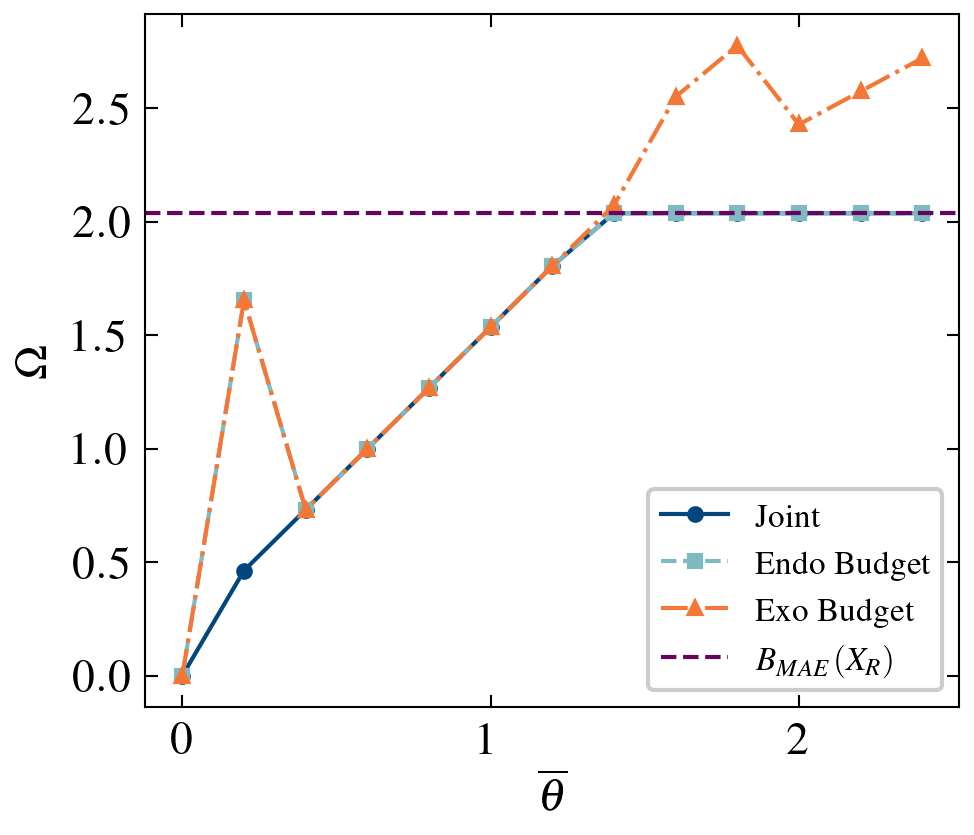

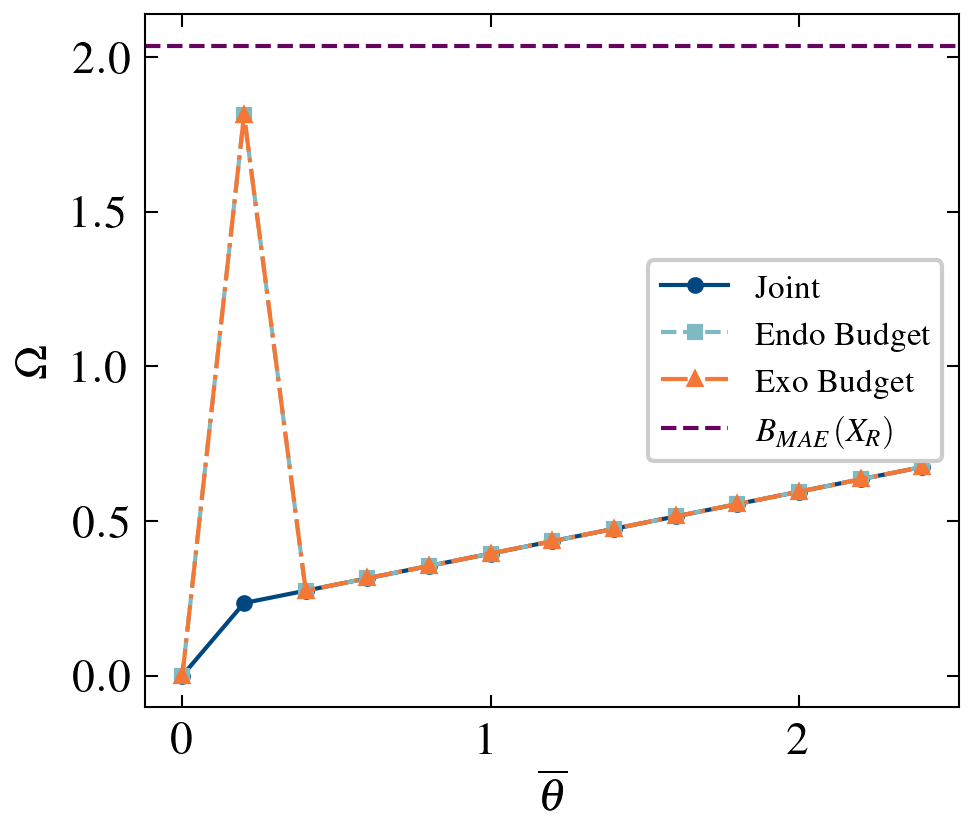

In [11]:
m = 0# market index
run = 0 # trial id
act_id = 4 # Actual metric id
dist = 0 # Distance metric id
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    axes.plot(sim.s_θ,
              sim.Ω_act[act_id,dist,run,:,corr,m,1],
              label='Joint')
    axes.plot(sim.s_θ,
              sim.Ω_act[act_id,dist,run,:,corr,m,0],
              label='Endo Budget')
    axes.plot(sim.s_θ,
              sim.Ω_act[act_id,dist,run,:,corr,m,2],
              label='Exo Budget')
    axes.axhline(sim.L_r[run,act_id], c=cpal[4], ls = '--', label = r'$B_{MAE}(X_R)$')
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$\Omega$')
    axes.legend()
    fig.savefig('figures/procurement/endo_act_{}.pdf'.format(corr))

## Benchmarks and Tasks

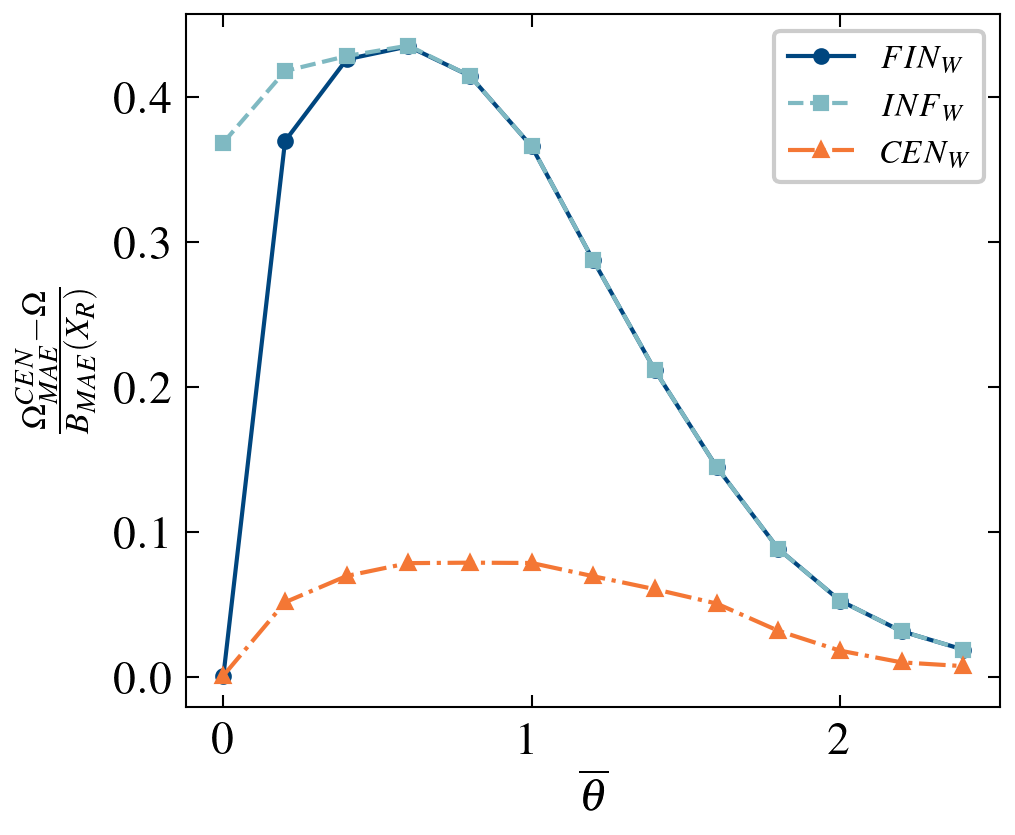

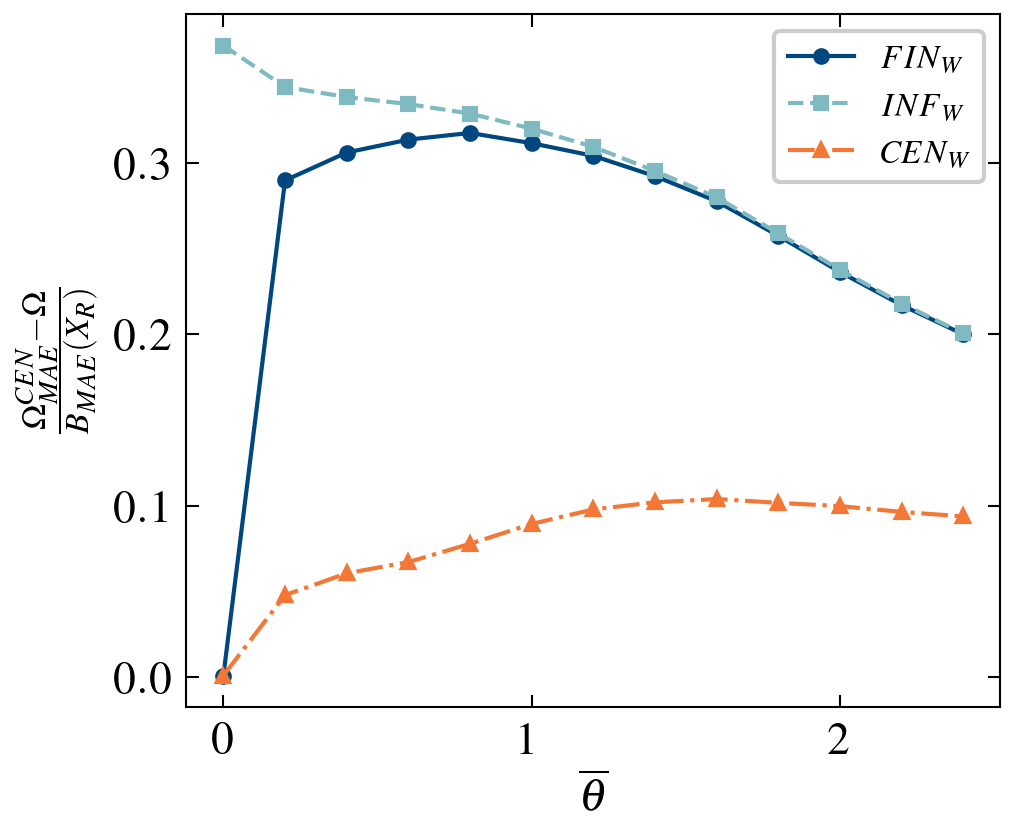

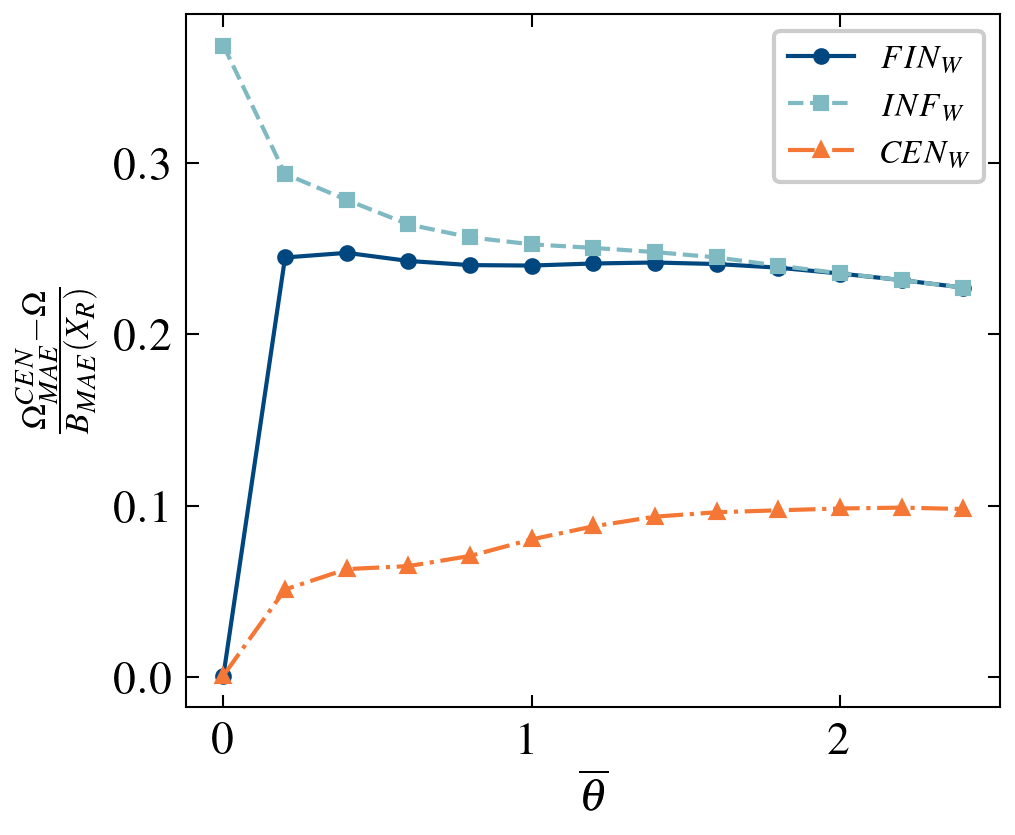

In [12]:
m = 0# market index
run = 0 # trial id
act_id = 4 # Actual metric id
dist = 0 # Distance metric id
mode = 1 # joint opt
labs = ['${FIN}_W$', '${INF}_W$', '${CEN}_W$']
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for m in range(len(sim.markets)):
        axes.plot(sim.s_θ,
                  np.mean(
                      sim.V_obj[:,:,corr,dist,m,mode] 
                      + sim.t[:,:,corr,dist,m,mode].sum(axis=-1) -
                      (sim.V_obj[:,:,corr,act_id,2,mode] 
                       + sim.t[:,:,corr,act_id,2,mode].sum(axis=-1))
                      , axis=0)/sim.L_r[run,act_id],
                  label=labs[m])
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$\frac{\Omega^{CEN}_{MAE} - \Omega}{B_{MAE}(X_R)}$')
    axes.legend()
    fig.savefig('figures/procurement/joint_perf_prop_{}.pdf'.format(corr))

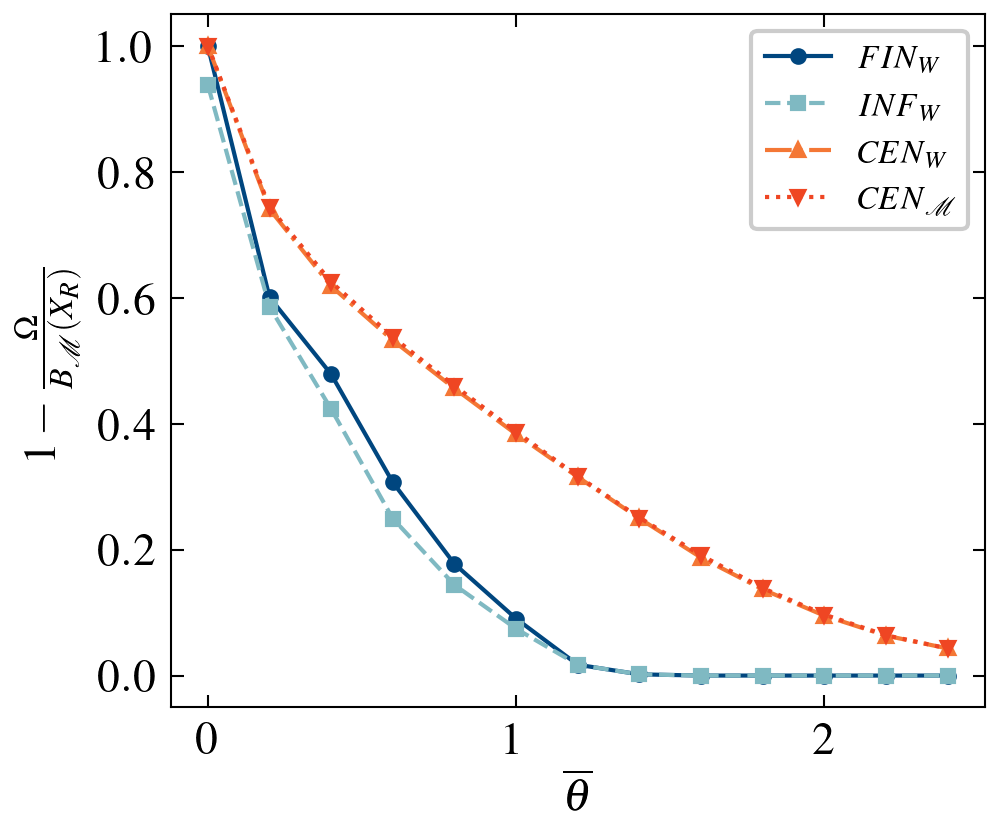

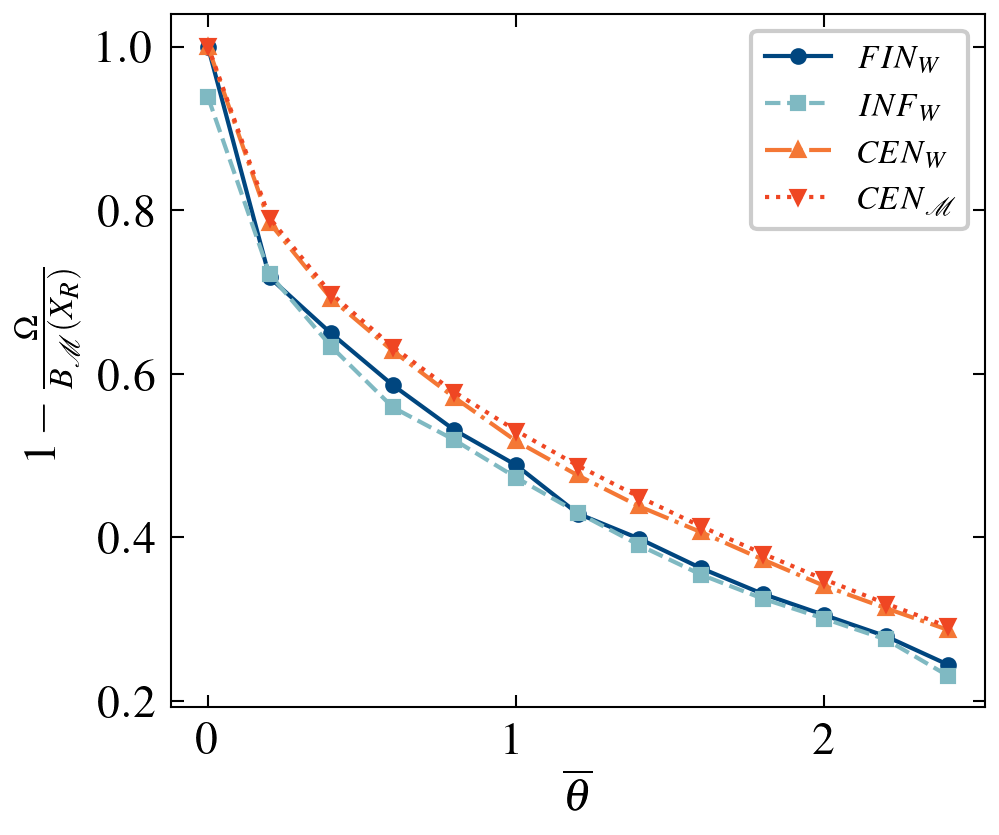

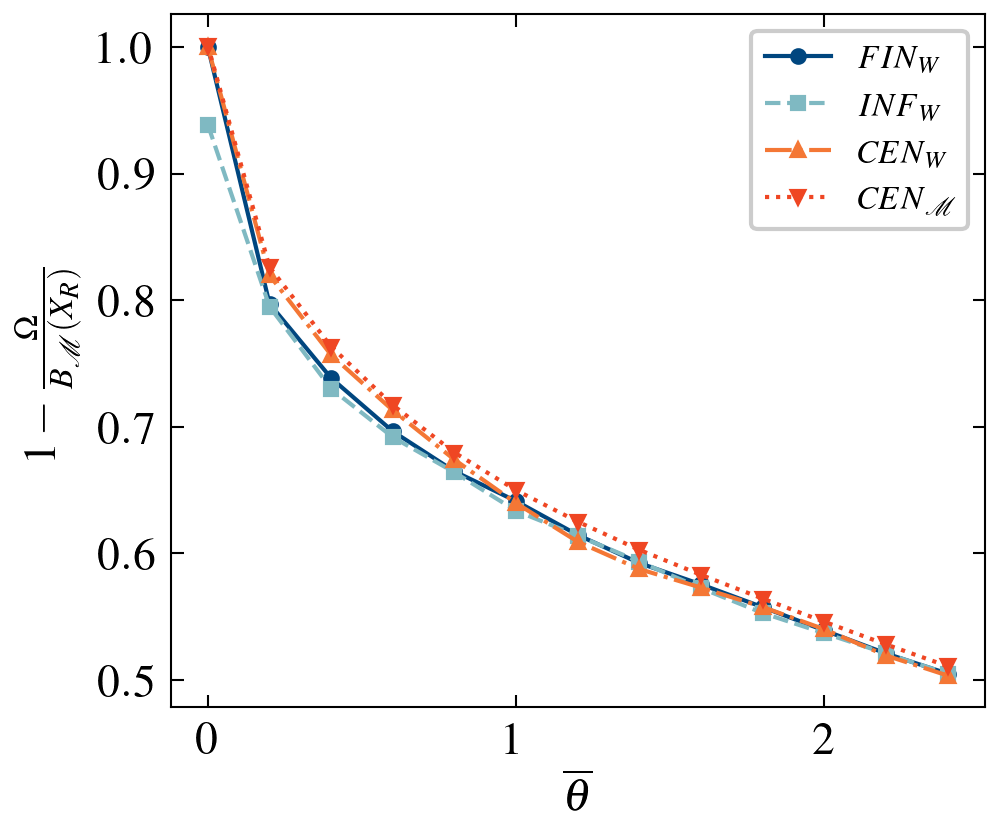

In [13]:
m = 0# market index
run = 0 # trial id
act_id = 5 # Actual metric id
dist = 1 # Distance metric id
mode = 1 # joint opt
labs = ['${FIN}_W$', '${INF}_W$', '${CEN}_W$']
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for m in range(len(sim.markets)):
        axes.plot(sim.s_θ,
                  np.mean(
                      1-(sim.Ω_act[act_id,dist,:,:, corr,m,mode].T
                           /sim.L_r[:sim.N_r,act_id])
                      , axis=1),
                  label=labs[m])
    axes.plot(sim.s_θ,
          np.mean(
              1-(sim.Ω_act[act_id,act_id,:,:, corr,2,mode].T
                           /sim.L_r[:sim.N_r,act_id])
              , axis=1),
          label='${CEN}_{\mathcal{M}}$')
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$1-\frac{\Omega}{B_{\mathcal{M}}(X_R)}$')
    axes.legend()
    fig.savefig('figures/procurement/joint_perf_{}.pdf'.format(corr))

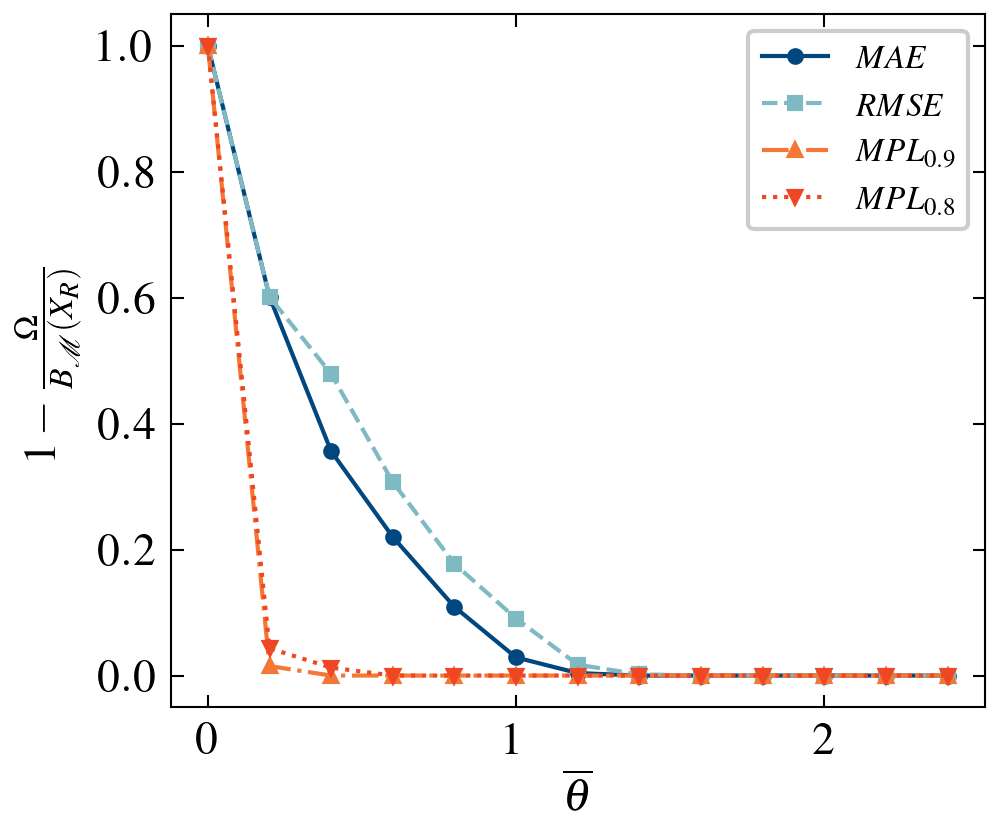

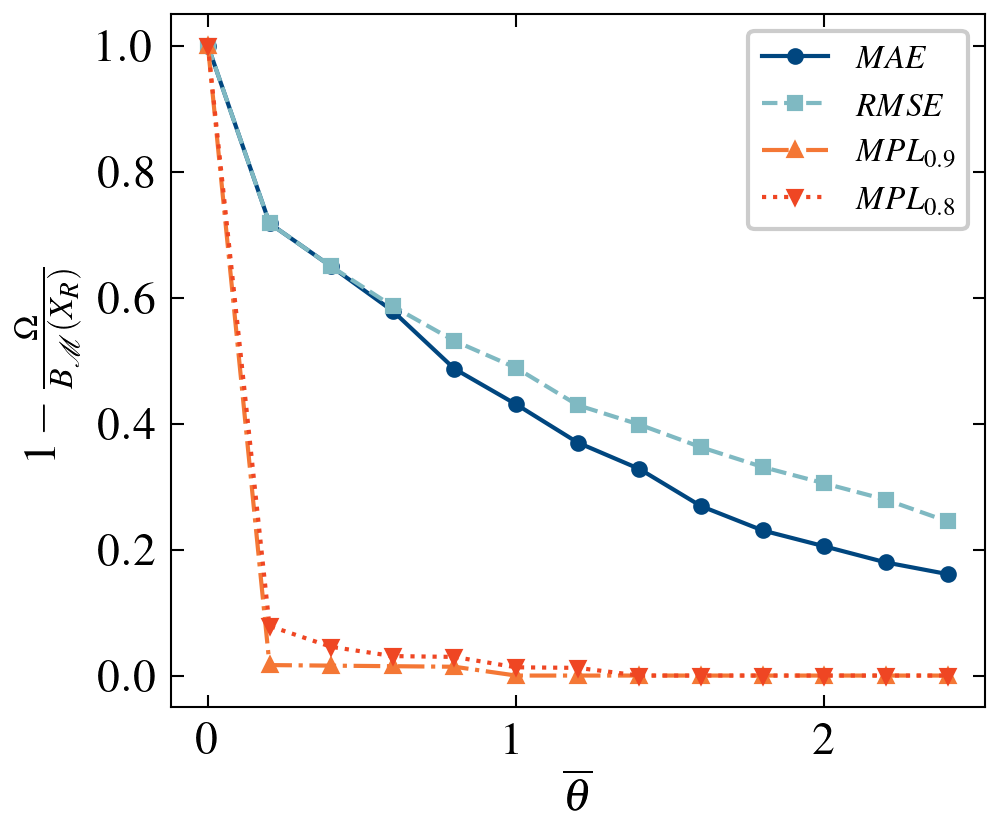

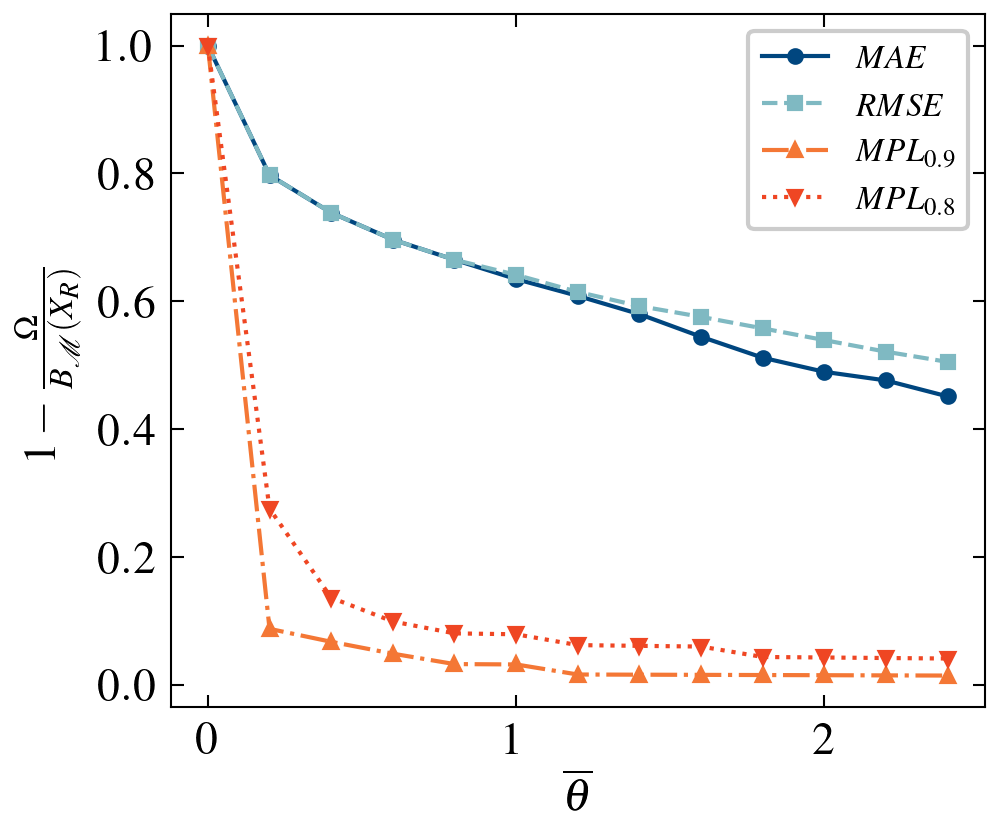

In [14]:
m = 0# market index
run = 0 # trial id
act_id = 5 # Actual metric id
dist = 1 # Distance metric id
mode = 1 # joint opt
labs = ['$MAE$', '$RMSE$', '$MPL_{0.9}$', '$MPL_{0.8}$']
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for d in range(4):
        axes.plot(sim.s_θ,
                  np.mean(
                      1-(sim.Ω_act[act_id,d,:,:, corr,0,mode].T
                           /sim.L_r[:sim.N_r,act_id])
                      , axis=1),
                  label=labs[d])
    axes.set_xlabel(r'$\overline\theta$')
    axes.set_ylabel(r'$1-\frac{\Omega}{B_{\mathcal{M}}(X_R)}$')
    axes.legend()
    fig.savefig('figures/procurement/joint_perf_task_{}.pdf'.format(corr))

## Risk Adjustment

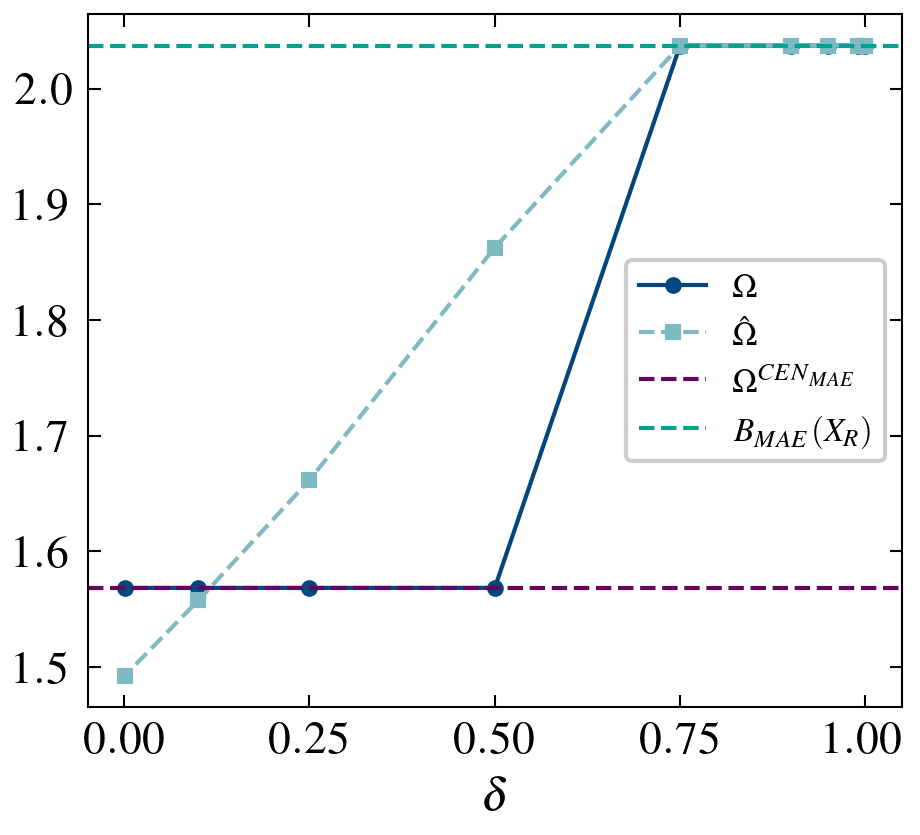

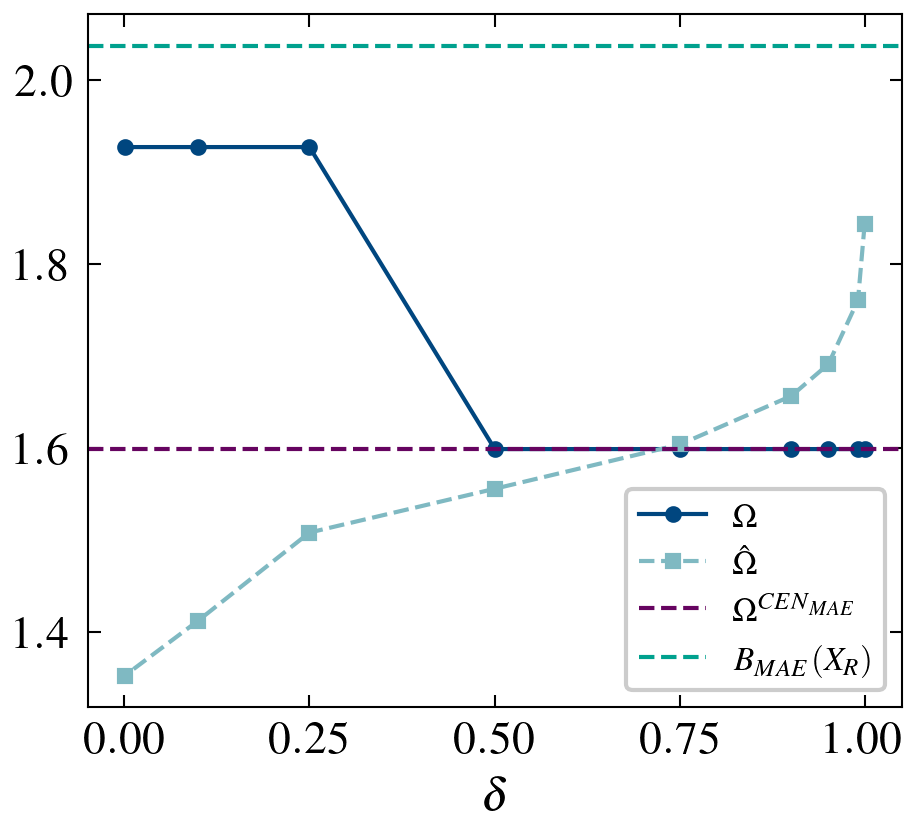

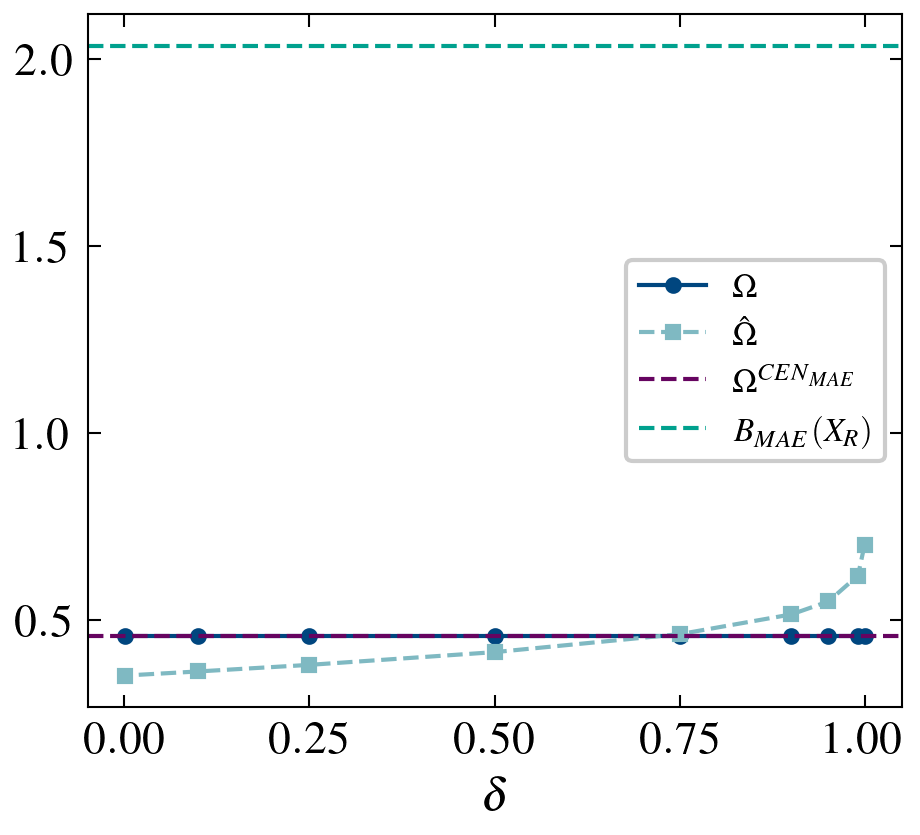

In [15]:
metric = 0
θ_id = 5
m = 0# market index
run = 0 # trial id
act_id = 4 # Actual metric id
dist = 0 # Distance metric id
mode = 1 # joint optmisation
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    axes.plot(sim.s_δ,
              sim.L_act_δ[run,θ_id,corr,:]
              + sim.t_δ[run,θ_id,corr,:].sum(axis=-1),
              label=r'$\Omega$')
    axes.plot(sim.s_δ,
              sim.V_δ[run,θ_id,corr,:] 
              + sim.t_δ[run,θ_id,corr,:].sum(axis=-1), label=r'$\hat\Omega$')
    axes.axhline(sim.Ω_act[metric,metric,run,θ_id,corr,2,mode],
                 c=cpal[4], ls = '--', label = r'$\Omega^{{CEN}_{MAE}}$')
    axes.axhline(sim.L_r[run,metric], c=cpal[5],
                 ls = '--', label = r'$B_{MAE}(X_R)$')
    axes.set_xlabel(r'$\delta$')
    axes.legend();
    fig.savefig('figures/procurement/endo_risk_{}.pdf'.format(corr))

C:\Users\Saurab\AppData\Local\Temp\ipykernel_3560\17820588.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='vertical')


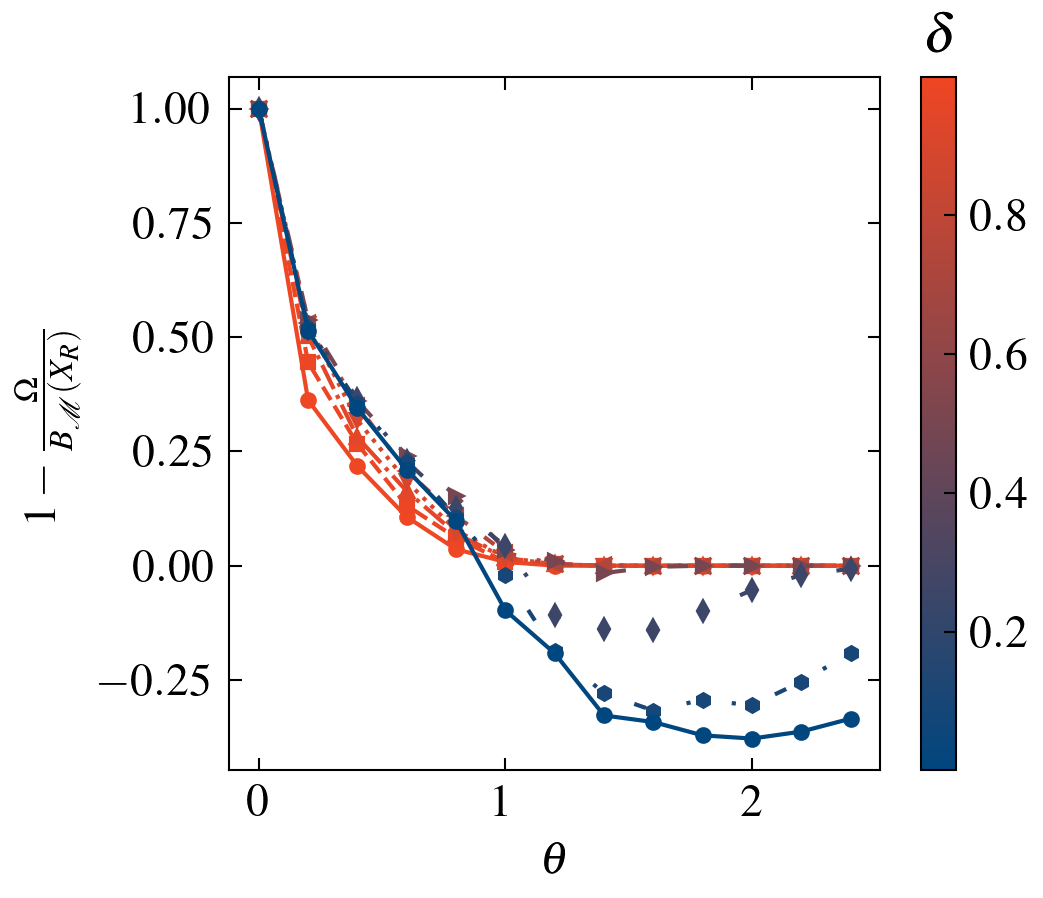

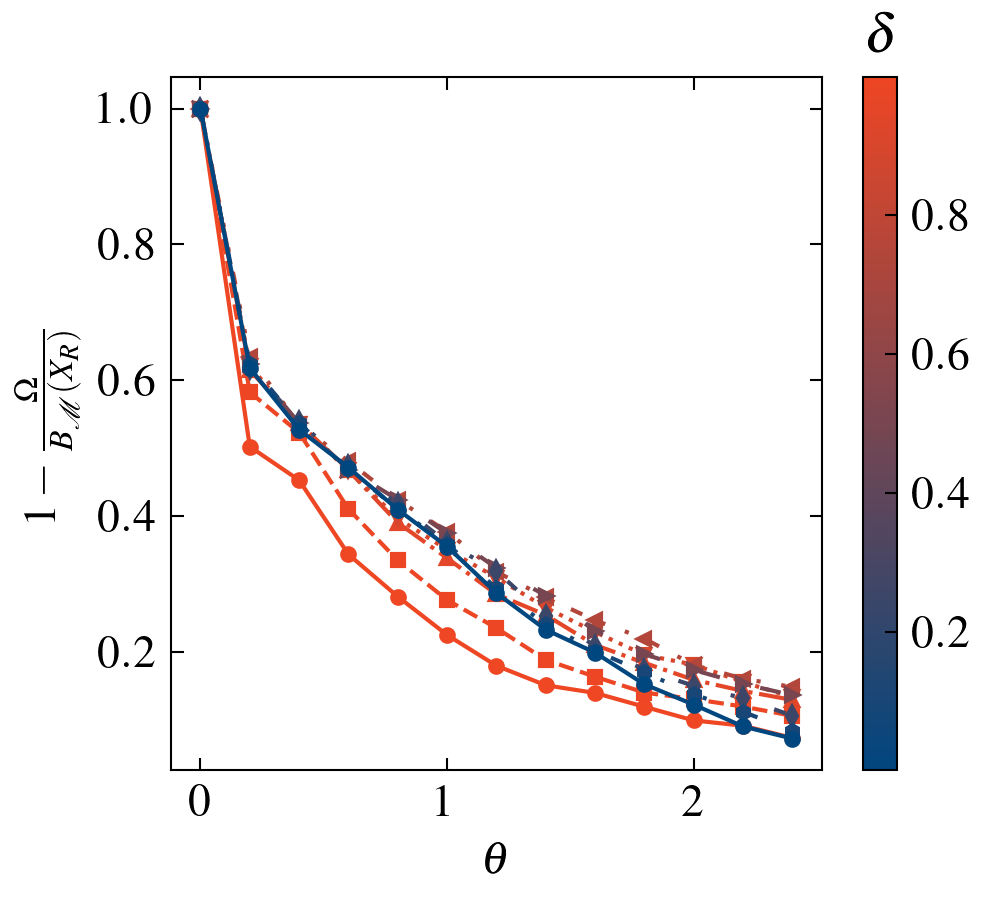

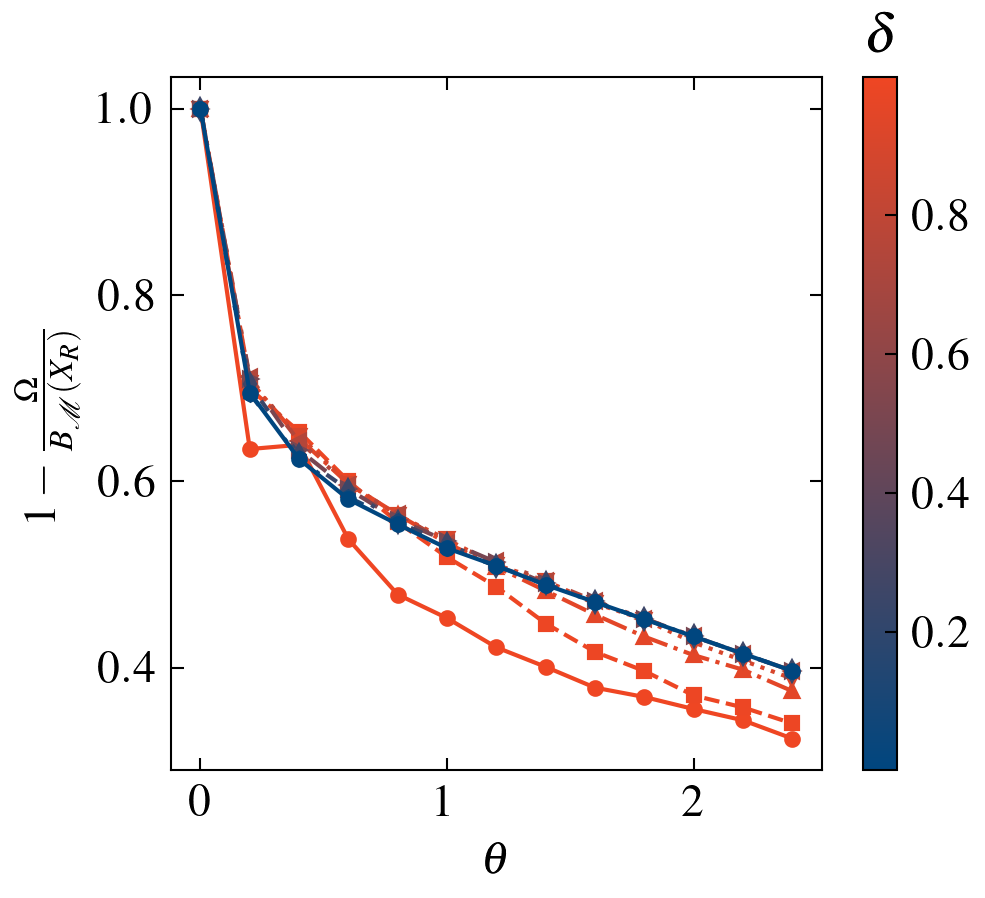

In [17]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
colors = [cpal[0],cpal[3]]
cmap = LinearSegmentedColormap.from_list('BB', colors, N=1000)
metric = 0
m = 0# market index
run = 0 # trial id
mode = 1 # joint optmisation
ran = max(sim.s_δ)-min(sim.s_δ)
for corr,_ in enumerate(sim.s_ρ):
    fig, axes = plt.subplots()
    for i,d in enumerate(sim.s_δ):
        axes.plot(sim.s_θ,
                  np.mean(
                  1- ((sim.L_act_δ[:,:,corr,i]
                  + sim.t_δ[:,:,corr,i].sum(axis=-1)).T/sim.L_r[:sim.N_r,metric]).T,
                  axis=0),
                  label=sim.s_δ[i], c= cmap((d-min(sim.s_δ))/ran))
    axes.set_xlabel(r'$\theta$')
    axes.set_ylabel(r'$1-\frac{\Omega}{B_{\mathcal{M}}(X_R)}$')
    # axes.legend()
    norm = matplotlib.colors.Normalize(min(sim.s_δ),max(sim.s_δ))
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),orientation='vertical')
    fig.axes[1].set(title='$\delta$');
    fig.savefig('figures/procurement/joint_risk_avg_{}.pdf'.format(corr))

## Levels of Approximation

In [34]:
import math
def newsvendor_shapley(V, N_d, N_r):   
    N_m_o = N_d + 1
    ϕ = np.zeros((N_m_o,N_r))
    M = [list(combinations(np.arange(N_d),i+1)) for i in range(N_d)]
    M = np.array([item for sublist in M for item in sublist], dtype=object)
    M_o = [list(combinations(np.arange(N_m_o),i+1)) for i in range(N_m_o)]
    M_o = np.array([item for sublist in M_o for item in sublist], dtype=object)

    # Generate extended value function
    V_M_o = np.zeros((N_r,len(M_o)))
    for i,c in enumerate(M_o):
        if N_m_o-1 in c and c != (N_m_o-1,):
            c_m = tuple(n for n in c if n != N_m_o-1)
            V_M_o[:,i] = V[:,list(M).index(c_m)]

    # Calculate shapley
    for i in range(N_m_o):
        idx = np.array([i in c for c in M_o])
        for c in M_o[idx]:
            c_c = tuple(n for n in c if n != i)
            if c_c == ():
                V_c_c = 0
            else:
                V_c_c = V_M_o[:,list(M_o).index(c_c)]
            V_c = V_M_o[:,list(M_o).index(c)]
            N_t = len(c)
            weight = math.factorial(N_t - 1) * math.factorial(N_m_o-N_t) / math.factorial(N_m_o)
            ϕ[i] += weight*(V_c - V_c_c)
    return ϕ

In [35]:
from models._markets import  CentralBudget, FixedFiniteMarket, FixedInfiniteMarket

In [36]:
N_r = 50
dist = 0
val = 4
θ_id = 4
corr = 1
mode = 1
Δ=1
δ_dp = 10**-5
δ_h=0.95
seed = 123412
ϵ_max = 5
metrics = [
    MeanAbsoluteError(),
    RootMeanSquaredError(),
    MeanPinballLoss(τ=0.9),
    MeanPinballLoss(τ=0.8)
]
valuator.Z = st.norm
sim.θ_bounds[1] = sim.s_θ[θ_id]
L = np.zeros((N_r, 4, valuator.N_c))
L_dp = np.zeros((N_r, 4, valuator.N_c))
W = np.zeros((N_r, 4, valuator.N_c))
W_dp = np.zeros((N_r, 4, valuator.N_c))
Ω = np.zeros((N_r, 4, 7))
ϵ = np.zeros((N_r, sim.N_d))
θ = np.zeros((N_r, sim.N_d))
q = np.zeros((N_r, 4, 7, sim.N_d))
t = np.zeros((N_r, 4, 7, sim.N_d))
for i in tqdm(range(N_r)):
    ϵ[i] = np.random.uniform(0.1,ϵ_max,sim.N_d)
    θ[i] = sim.generate_reserve_prices(
        sim.θ_bounds[0],
        sim.θ_bounds[1],
        0, ϵ[i], seed)  # reserve prices
    β_in = np.sqrt(valuator.β[i]**2 + (2*(Δ**2)*np.log(1.25/δ_dp))/ϵ[i]**2)
    α_T_dp, β_T_dp = valuator.dist_aggregator(valuator.α[i], β_in)
    α_T, β_T = valuator.dist_aggregator(valuator.α[i], valuator.β[i])
    for m in range(4):
        #V = W(X_c,X_T_dp) + W(X_dp,0) 
        for n, c in enumerate(valuator.C):
            β_in = np.sqrt((2*(Δ**2)*np.log(1.25/δ_dp))/ϵ[i,c]**2)
            α_C_dp, β_C_dp = valuator.dist_aggregator(valuator.α[i, c], β_in)
            α_C, β_C = valuator.dist_aggregator(valuator.α[i, c], valuator.β[i, c])
            W[i,m,n] = WassersteinMetric().closed_form(α_C, β_C, α_T, β_T)
            W_dp[i,m,n] = (WassersteinMetric().closed_form(α_C, β_C, α_T, β_T)
                         + WassersteinMetric().closed_form(0, β_C, 0, 0))
            L[i,m,n] = metrics[m].closed_form(α_C, β_C, α_T, β_T)
            L_dp[i,m,n] = metrics[m].closed_form(α_C_dp, β_C_dp, α_T, β_T)
        args = {
            'V_c': L[i,m] - L[i,m,-1],
           'θ': np.squeeze(θ[i]),
           'L_r': (L[i,m] - L[i,m,-1]).max(axis=-1),
            'θ_params':sim.θ_bounds,
            'Z': st.uniform,
            'B': (L[i,m] - L[i,m,-1]).max(axis=-1)
        }
        run_args = {
            'joint':True,
            'endogenous':True,
            'bayesian':False
        }
        res = CentralBudget(**args).run(**run_args)
        q[i,m,1] = res['q']
        t[i,m,1] = res['t']
        Ω[i,m,1] = get_actual_value(
            L[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])
        run_args = {
            'joint':True,
            'endogenous':True,
            'bayesian':True
        }
        res = CentralBudget(**args).run(**run_args)
        q[i,m,2] = res['q']
        t[i,m,2] = res['t']
        Ω[i,m,2] = get_actual_value(
            L[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])
        args['V_c'] = W[i,m]
        res = CentralBudget(**args).run(**run_args)
        q[i,m,3] = res['q']
        t[i,m,3] = res['t']
        Ω[i,m,3] = get_actual_value(
            L[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])
        args['V_c'] = W_dp[i,m]
        res = CentralBudget(**args).run(**run_args)
        q[i,m,4] = res['q']
        t[i,m,4] = res['t']
        Ω[i,m,4] = get_actual_value(
            L_dp[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])
        args = {
            'V_c': W_dp[i,m],
            'θ': np.squeeze(θ[i]),
            'L_r': (L[i,m] - L[i,m,-1]).max(axis=-1),
            'θ_params':sim.θ_bounds,
            'Z': st.uniform,
            'K': metrics[m].K,
            'δ': δ_h            
        }
        run_args = {
            'budget':False,
            'endogenous':False
        }
        res = FixedFiniteMarket(**args).run(**run_args)
        q[i,m,5] = res['q']
        t[i,m,5] = res['t']
        Ω[i,m,5] = get_actual_value(
            L_dp[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])
        res = FixedInfiniteMarket(**args).run(**run_args)
        q[i,m,6] = res['q']
        t[i,m,6] = res['t']
        Ω[i,m,6] = get_actual_value(
            L_dp[i,m],
            res['q'],
            valuator.C,
            args['L_r']
        )[0] + sum(res['t'])

  0%|          | 0/50 [00:00<?, ?it/s]

Set parameter Username


gurobipy.gurobipy INFO  Set parameter Username


Academic license - for non-commercial use only - expires 2025-10-29


gurobipy.gurobipy INFO  Academic license - for non-commercial use only - expires 2025-10-29


In [37]:
for i in range(N_r):
    for m in range(4):
        # Shapley
        V_mae = (L[i,m] - L[i,m,-1]).max(axis=-1) - (L[i,m] - L[i,m,-1])
        Ω[i,m,0] = np.sum(newsvendor_shapley(V_mae.reshape(-1,1).T, sim.N_d, 1)[:-1])

In [31]:
res = [L_dp ,W,W_dp ,Ω ,ϵ,θ,q ,t]
with open('data/procurement/waterfall_{}_{}.pkl'.format(N_d,N_r), 'wb') as f:
    pkl.dump(res, f)

In [18]:
with open('data/procurement/waterfall_{}_{}.pkl'.format(N_d,N_r), 'rb') as f:
    L_dp ,W,W_dp ,Ω ,ϵ,θ,q ,t = pkl.load(f)

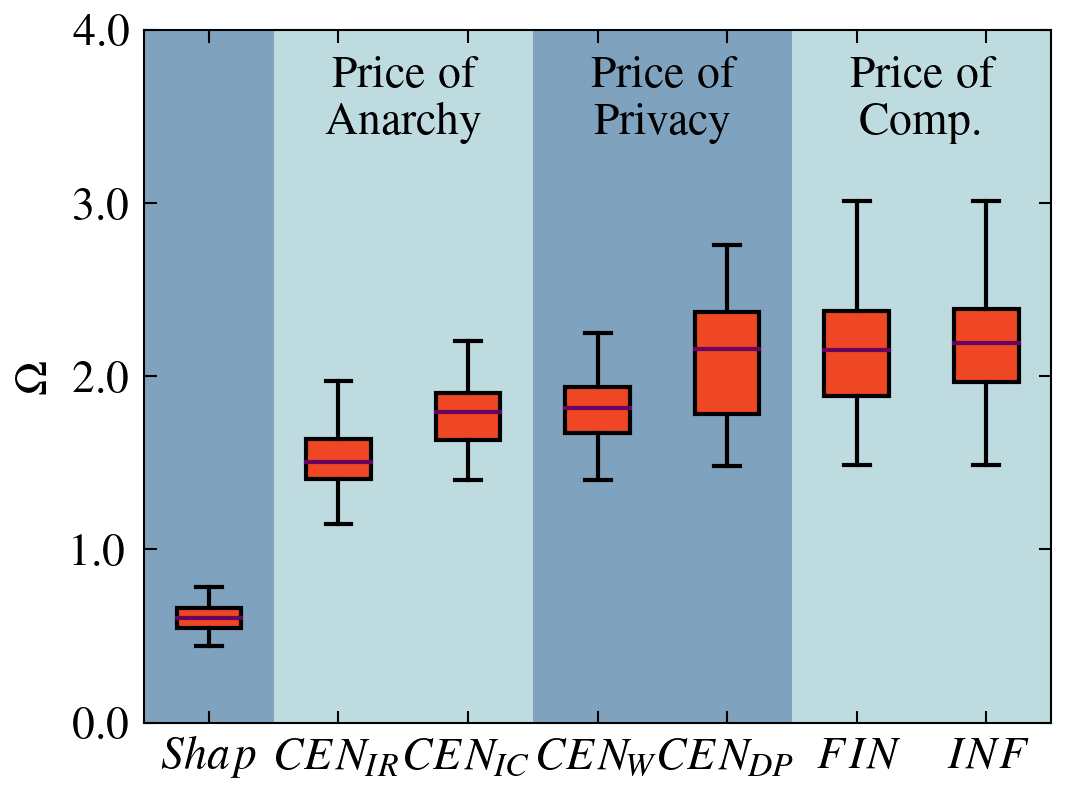

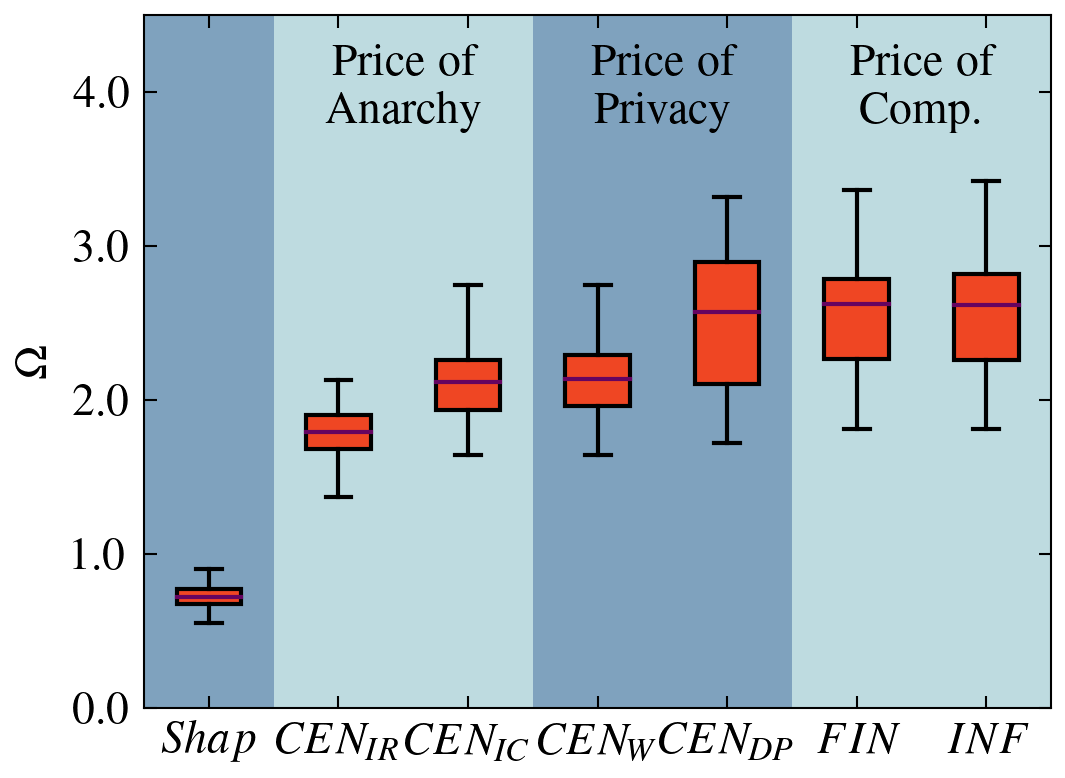

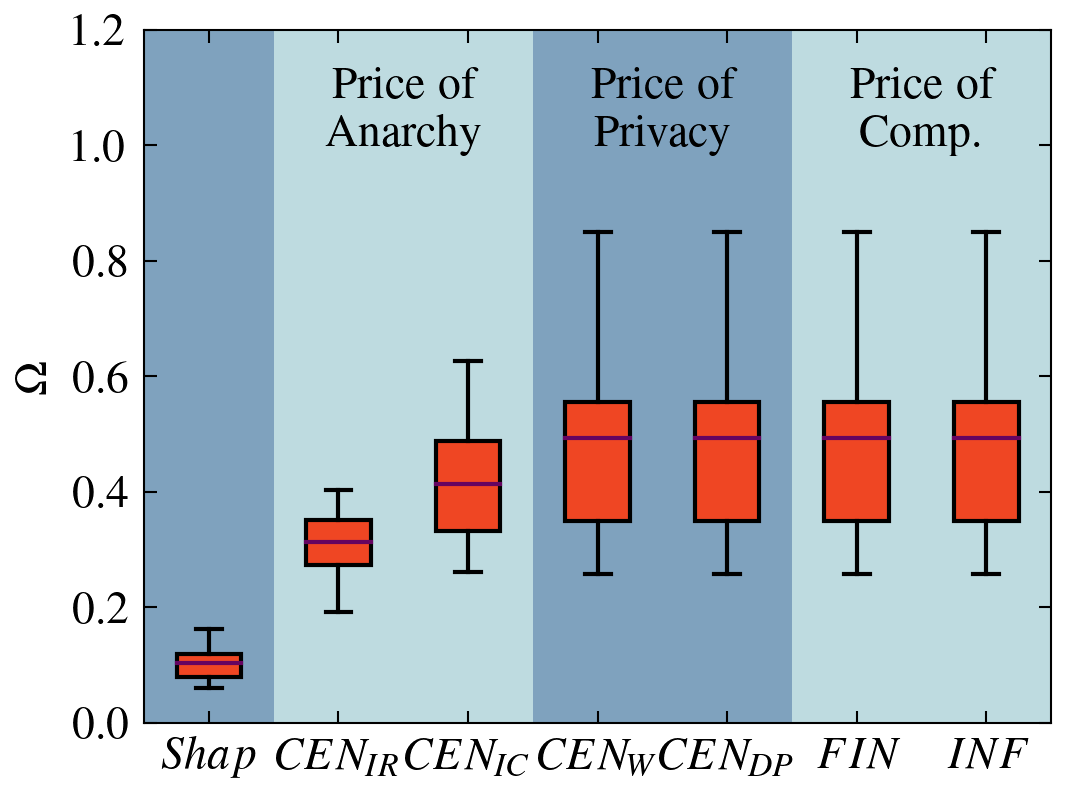

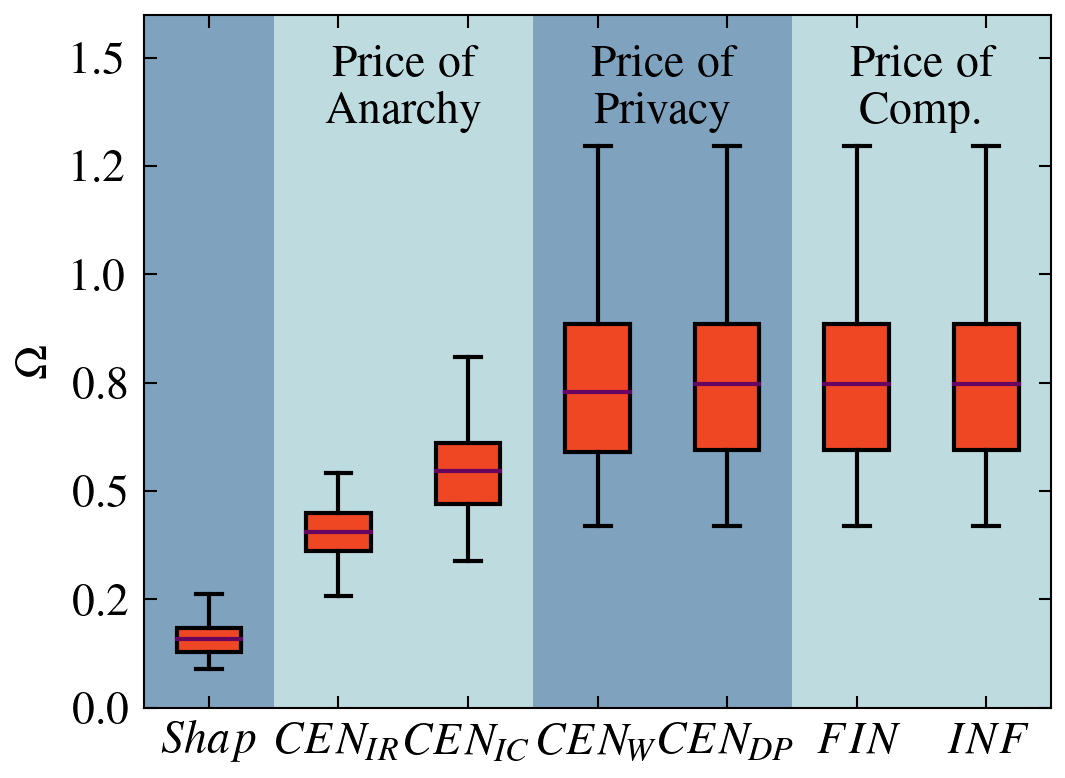

In [19]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'figure.figsize': [3.9,3]})
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'legend.fontsize': 8})
tops = [3.4,3.8,1,1.35]
for m in range(4):
    fig,axes = plt.subplots()
    bplot = axes.boxplot(
        Ω[:,m],
        vert=True,
        patch_artist=True,
        capwidths = 0.2,
        medianprops=dict(color=cpal[3], ls=''),
        meanprops=dict(color=cpal[4], ls='-'),
        showmeans = True,
        showfliers=False,
        meanline = True
    )
    axes.axvspan(0.5, 1.5, facecolor=cpal[0], alpha=0.5, zorder=0,linewidth=0)
    axes.axvspan(1.5, 3.5, facecolor=cpal[1], alpha=0.5, zorder=0,linewidth=0)
    axes.axvspan(3.5, 5.5, facecolor=cpal[0], alpha=0.5, zorder=0,linewidth=0)
    axes.axvspan(5.5, 7.5, facecolor=cpal[1], alpha=0.5, zorder=0,linewidth=0)
    # fill with colors
    for patch in bplot['boxes']:
        patch.set_facecolor(cpal[3])
    for spine in axes.spines.values():
        spine.set_edgecolor('k')
    axes.set_xticklabels(labels = ['$Shap$', '$CEN_{IR}$','$CEN_{IC}$','$CEN_{W}$','$CEN_{DP}$', '$FIN$', '$INF$'])
    ticks = axes.get_yticks()
    diff = np.diff(ticks).mean()
    axes.set_ylim([0,ticks.max()+diff])
    # axes.set_xlim([0,7])
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axes.set_ylabel('$\Omega$')
    axes.text(2.5, tops[m], 'Price of\n Anarchy', ha='center')
    axes.text(4.5, tops[m], 'Price of\n Privacy', ha='center');
    axes.text(6.5, tops[m], 'Price of\n Comp.', ha='center');
    fig.savefig('figures/procurement/waterfall_{}.pdf'.format(m))